### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files to plot JES/JER up/down distribution

Enviroment needed for this script: HWW

(I have exported the enviroment needed for this script, assume you have `Conda` installed in your terminal, then enter `../envs/` directory, and use  `conda env create -f HWW.yml` to create the enviroment)




### Import necessary modules

In [1]:
import numpy as np
import os
import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from scipy import interpolate
from cycler import cycler
import uproot
import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings
import hist as hist2
import pyarrow
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass
from copy import deepcopy
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector


/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/data/pku/home/zhaoyz/anaconda3/envs/HWW/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allo

Welcome to JupyROOT 6.28/04


### Read SlimmedTree files

In [2]:
#load the slimmedtree files using uproot

#different year available here.
# year = "2016"
# year = "2017"
year = "2018"
# year = "Full-Run2"

#if run on PKU cluster, use this:
CustNanoData = {
    'TotalSignal' : "/data/bond/zhaoyz/SlimmedTree/V6/%s/Signal/SlimmedTree_Total.root"%(year),
    'ggF'         : "/data/bond/zhaoyz/SlimmedTree/V6/%s/Signal/SlimmedTree_GluGlu.root"%(year),
    'VH'          : "/data/bond/zhaoyz/SlimmedTree/V6/%s/Signal/SlimmedTree_VH.root"%(year),
    'ttH'         : "/data/bond/zhaoyz/SlimmedTree/V6/%s/Signal/SlimmedTree_ttH.root"%(year),
    'VBF'         : "/data/bond/zhaoyz/SlimmedTree/V6/%s/Signal/SlimmedTree_VBF.root"%(year),
} 

files = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })


### Get DPhi in the events

In [3]:
def get_dphi(events):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events["Mj_corr_V2_a"]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )
    delta_phi = np.subtract(vec_MET.phi, vec_higgs.phi)
    delta_phi = np.where(delta_phi > np.pi, delta_phi - 2*np.pi, delta_phi)
    delta_phi = np.where(delta_phi < -np.pi, delta_phi + 2*np.pi, delta_phi)
    delta_phi = np.abs(delta_phi)
    print(delta_phi)
    events["DPhi"] = delta_phi

for k in files:
    print("Add dphi of:",k)
    get_dphi(events=files[k])

Add dphi of: TotalSignal
[0.486, 0.0852, 2.85, 0.551, 1.49, 0.535, ... 0.743, 0.839, 2.31, 2.44, 2.99, 0.506]
Add dphi of: ggF
[0.486, 0.0852, 2.85, 0.551, 1.49, 0.535, ... 3.09, 0.722, 3, 3.11, 3.07, 0.455]
Add dphi of: VH
[3.03, 1.91, 0.382, 2.28, 0.302, 3.03, ... 3.1, 0.141, 0.273, 0.498, 1.18, 2.73]
Add dphi of: ttH
[1.1, 0.131, 0.429, 1.78, 2.46, 0.0163, ... 0.743, 0.839, 2.31, 2.44, 2.99, 0.506]


Add dphi of: VBF
[0.435, 1.79, 3.09, 0.797, 2.77, 0.561, ... 1.13, 0.332, 2.5, 2.82, 2.01, 2.45]


### Get MET recovery mass(consider the JES/JER up/down content)

In [4]:

def get_reco(events,mass = "Mj_corr_V2_a"):
    pT_higgs   = events["PTj_V2_a"]
    eta_higgs  = events["Etaj_V2_a"]
    phi_higgs  = events["Phij_V2_a"]
    mass_higgs = events[mass]
    pT_MET = events["MET_et"]
    eta_MET = events["Etaj_V2_a"]
    phi_MET = events["MET_phi"]
    mass_MET = ak.zeros_like(events["MET_phi"])
    vec_higgs = ak.zip({
        "pt"   : pT_higgs   ,
        "eta"  : eta_higgs  ,
        "phi"  : phi_higgs  ,
        "mass" : mass_higgs ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_MET = ak.zip({
        "pt"   :   pT_MET   ,
        "eta"  :  eta_MET  ,
        "phi"  :  phi_MET  ,
        "mass" : mass_MET ,
    },
    with_name="PtEtaPhiMLorentzVector",
    behavior=vector.behavior,
    )

    vec_sum = vec_MET + vec_higgs
    mH_reco = vec_sum.mass
    mass_str = "MH_Reco" if mass == "Mj_corr_V2_a" else mass
    events[mass_str] = ak.where(( (events["DPhi"] < 0.8) & (events["MET_et"]/events["PTj_V2_a"] > 0.1)), mH_reco, events[mass])

for k in files:
    print("Add reco of:",k)
    get_reco(events=files[k])
    get_reco(events=files[k],mass = "Mj_jesTotalUp_a")
    get_reco(events=files[k],mass = "Mj_jesTotalDown_a")
    get_reco(events=files[k],mass = "Mj_jerUp_a")
    get_reco(events=files[k],mass = "Mj_jerDown_a")

Add reco of: TotalSignal


Add reco of: ggF
Add reco of: VH
Add reco of: ttH
Add reco of: VBF


### output all the variables for which we can make plots

In [5]:
files["VBF"].fields

['a_TopbWq1c',
 'Phij_V2_c',
 'PTj_V2_b',
 'PTj_2',
 'a_HWqqWq2c',
 'a_QCDcc',
 'R3q_a',
 'Etaj_mid',
 'Mj_V2_a',
 'puWeightUp',
 'weight',
 'R4q_a',
 'gKK_g_c',
 'a_QCDc',
 'MET_phi_NoXYCorr',
 'u_c',
 'MET_T1Smear_phi_XYcorr',
 'nb_m_deep_ex',
 'Rlq_b',
 'R3q_b',
 't_c',
 'a_HWqqWqq1c',
 'w_b',
 'a_Hcc',
 'Mj_corr',
 'tlqq_b',
 'Etaj_2',
 'R2q_b',
 'Mj',
 'c_HWW_V2',
 'Mj_mid',
 'Mj_min',
 'Rlq_c',
 'a_Htauhtaue',
 'gKK_g_b',
 'Mj_jerUp_c',
 'Mj_max',
 'w_c',
 'Etaj_V2_a',
 'PTj_mid',
 'a_HWqqWmv0c',
 'a_Hqq',
 'a_HWqqWmv1c',
 'MET_et',
 'a_QCDothers',
 'a_TopbWev',
 'R2q_c',
 'a_TopbWtaumv',
 'R4q_c',
 'a_QCDbb',
 'a_Htauhtaum',
 'a_Htauhtauh',
 'Phij_min',
 'ST',
 'a_HWqqWq1c',
 'Etaj_max',
 'Etaj_min',
 'SF',
 'Mj_corr_3',
 'w_a',
 'a_HWqqWtauhv0c',
 'a_HWqqWtauev0c',
 'Mj_corr_2',
 'Rlqq_a',
 'MJJJ',
 'a_HWqqWq0c',
 'a_HWqqWtauhv1c',
 'MET_phi',
 'Mj_3',
 'Mj_corr_c',
 't_b',
 'a_TopbWqq0c',
 'Nj4_in',
 't_a',
 'PTj_3',
 'PTj_V2_c',
 'c_HWWvsQCD_V2',
 'Mj_jerDown_b',
 'a_HWW_V2',

### plot setting, error setting, histogram setting

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


In [8]:
MAIN_DIR = "."

plot_dir = f"{MAIN_DIR}/plots/variation/5Mar24"
_ = os.system(f"mkdir -p {plot_dir}")

### define main plots function

In [11]:
def plot_JES_JER_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_JES = True,year = "2018"):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_JES:
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jesTotalUp_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="JES,total up", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jesTotalDown_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="JES,total down", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="JES,total up/center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="JES,total down/center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region + ", total signal",fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/JES_{year}_{region}.pdf", bbox_inches='tight')    
    else: 
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jerUp_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="JER,up", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["Mj_jerDown_a"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="JER,down", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="JER,up/center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="JER,down/center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region+ ", total signal",fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/JER_{year}_{region}.pdf", bbox_inches='tight')    

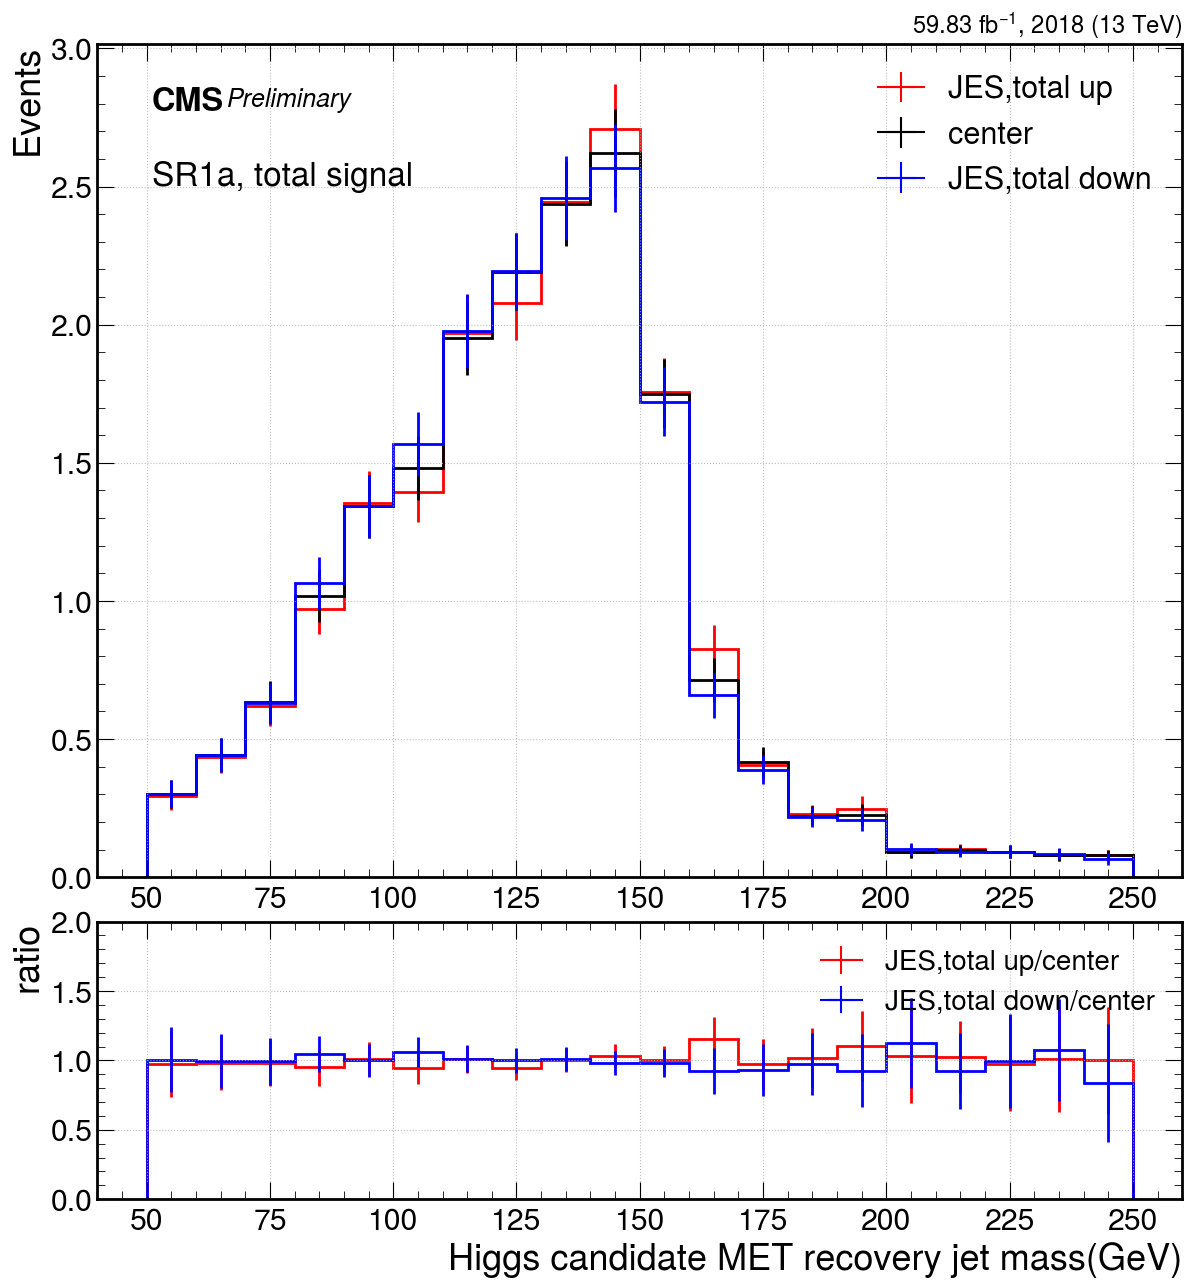

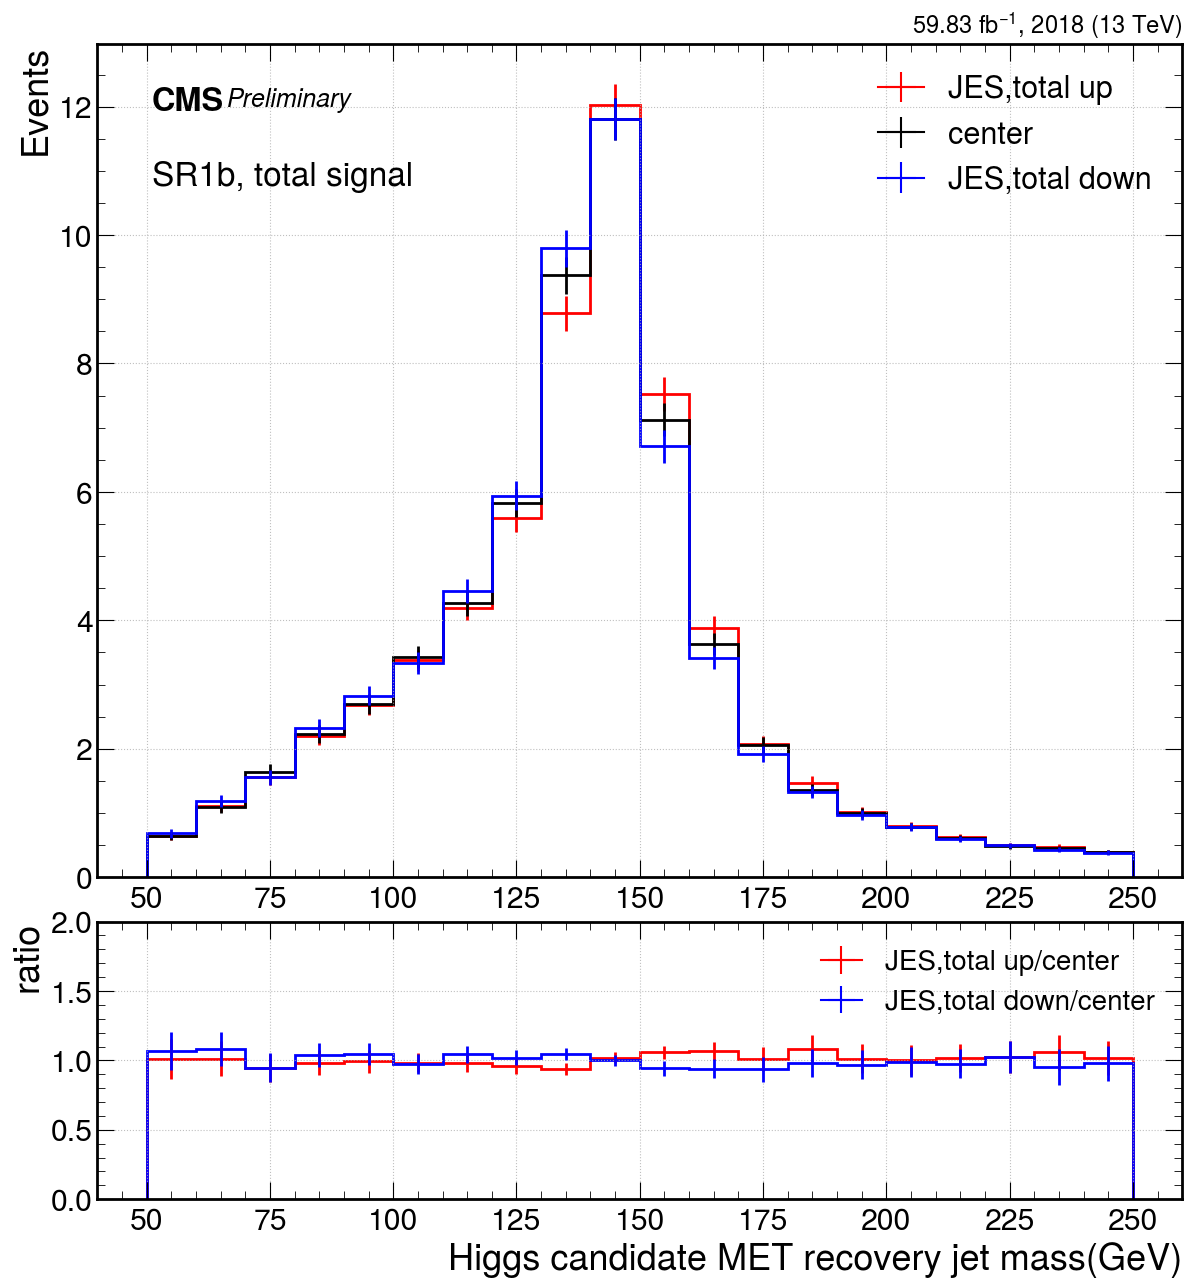

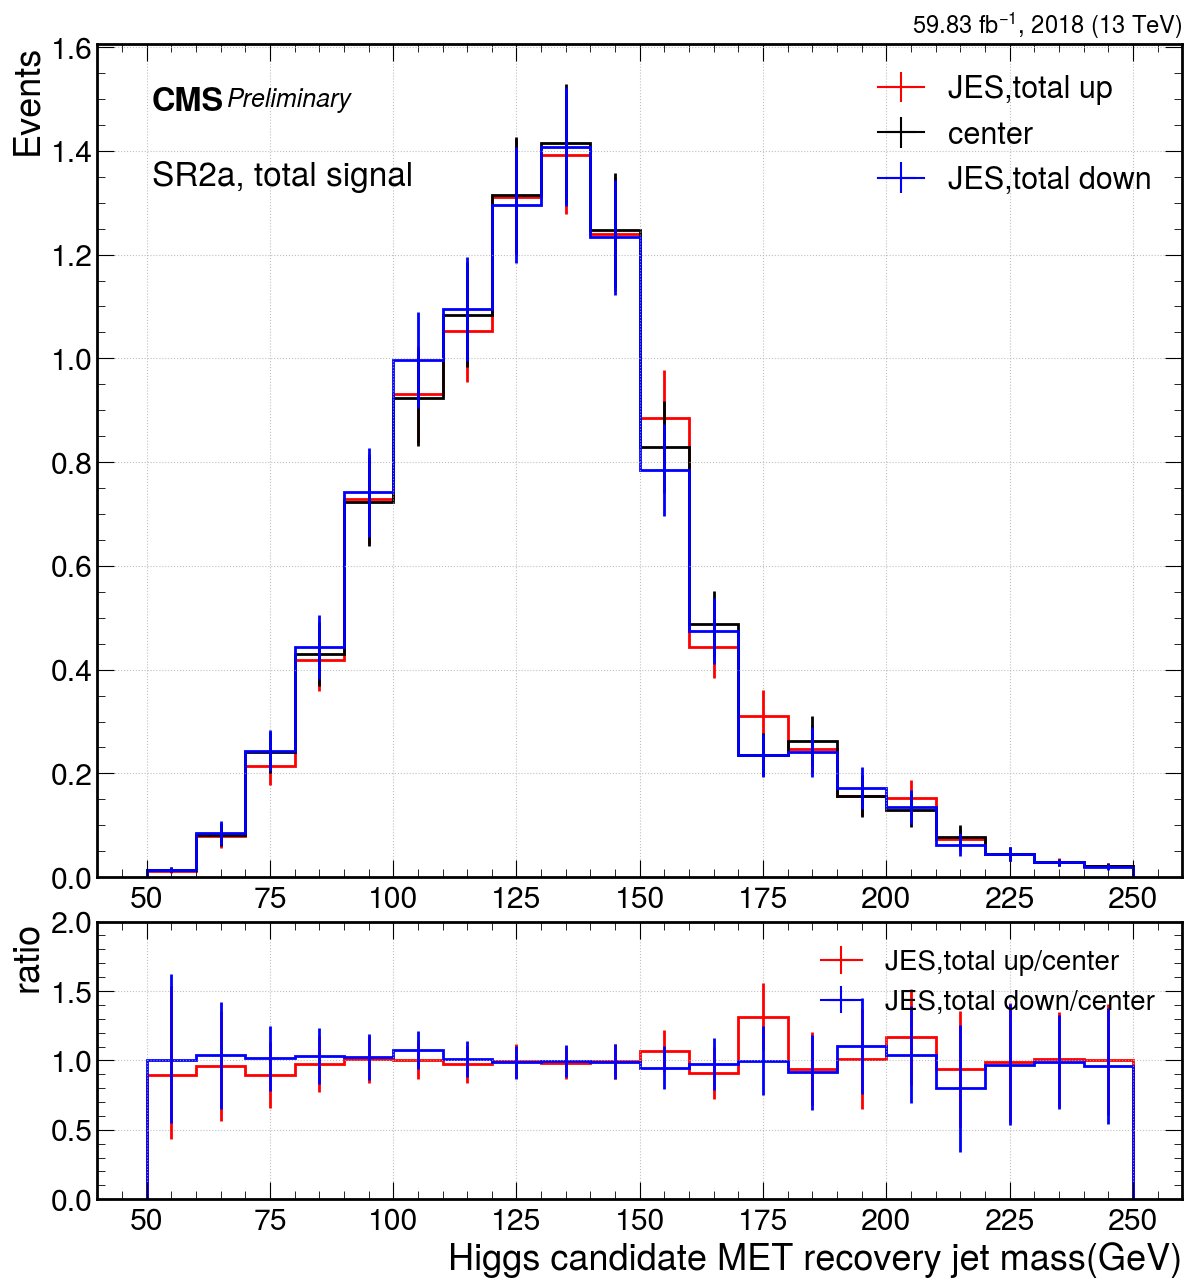

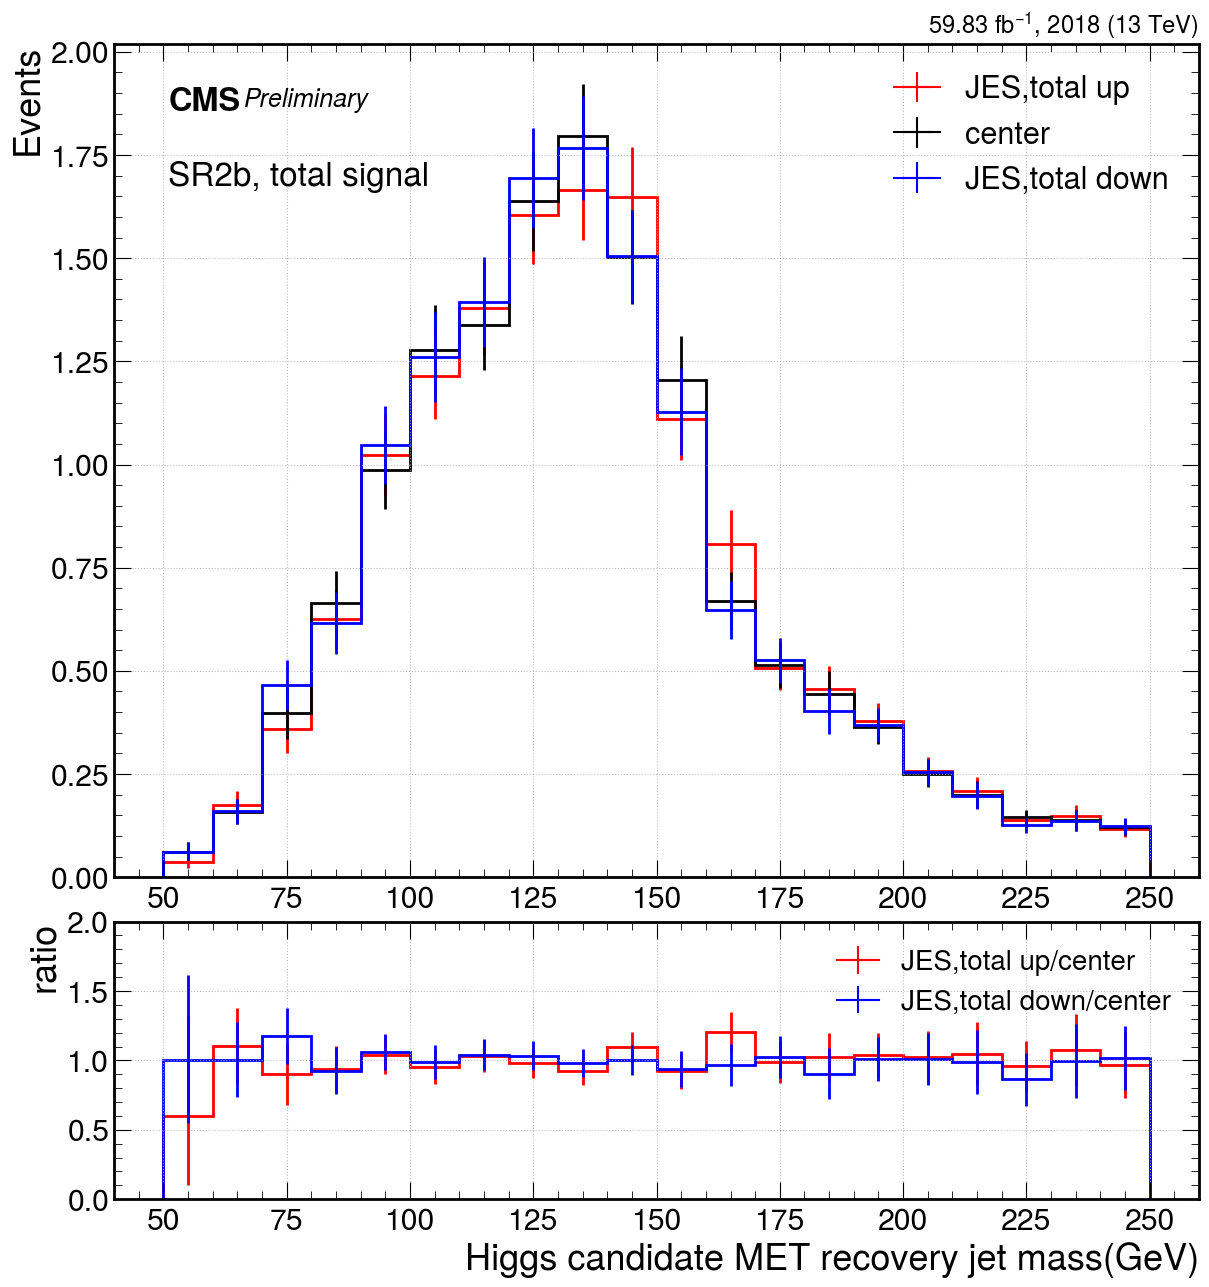

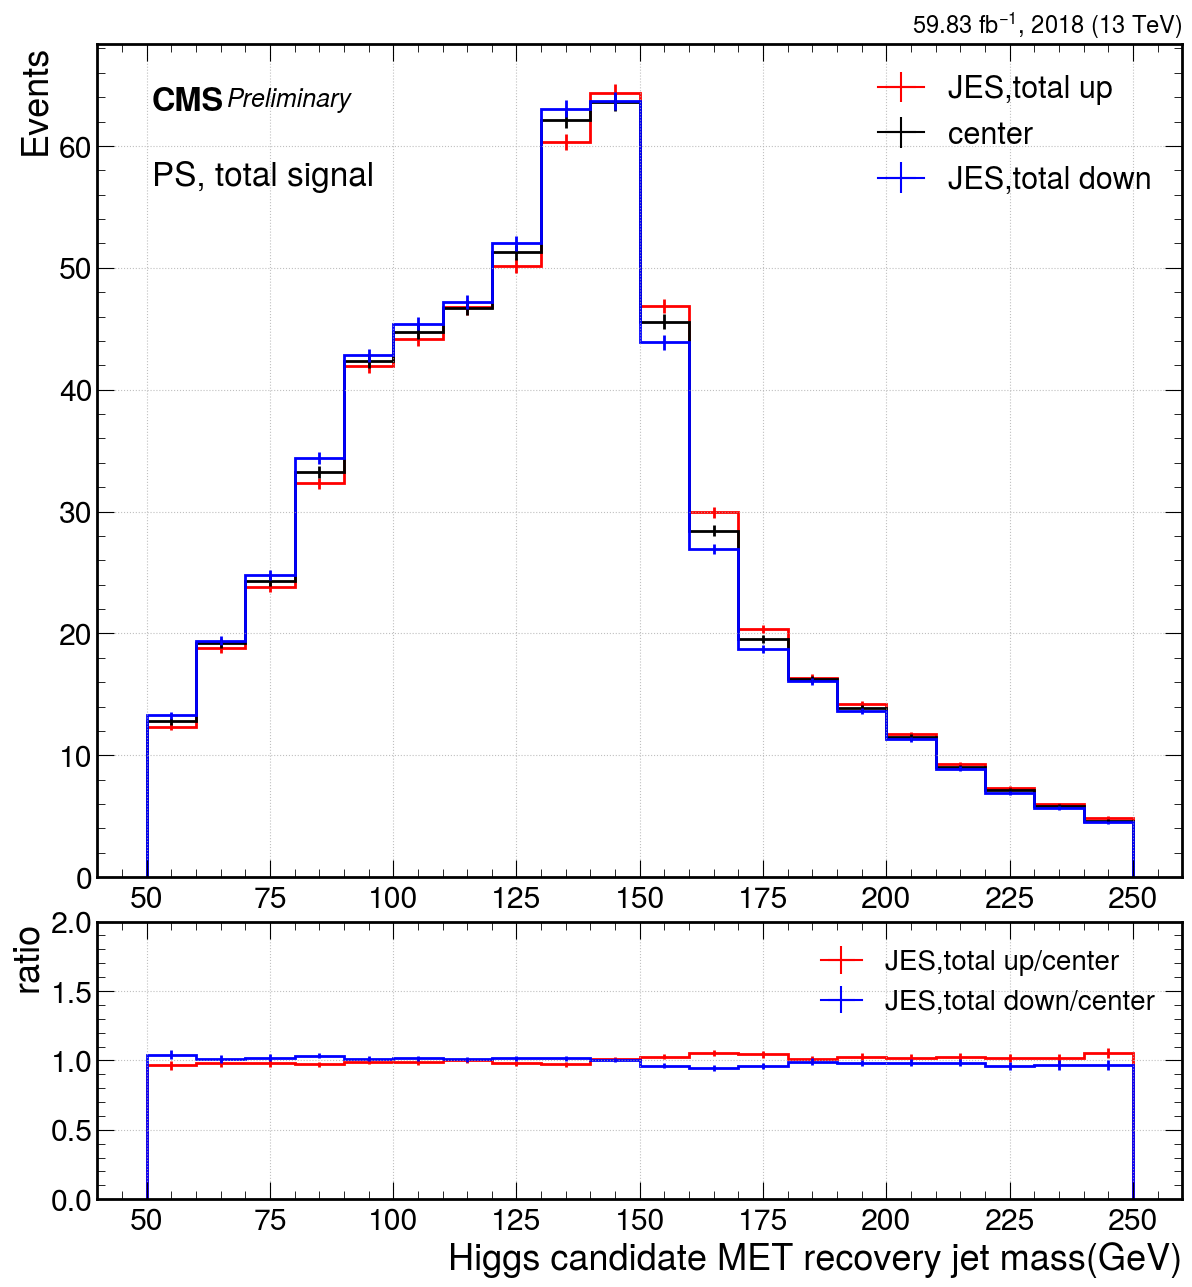

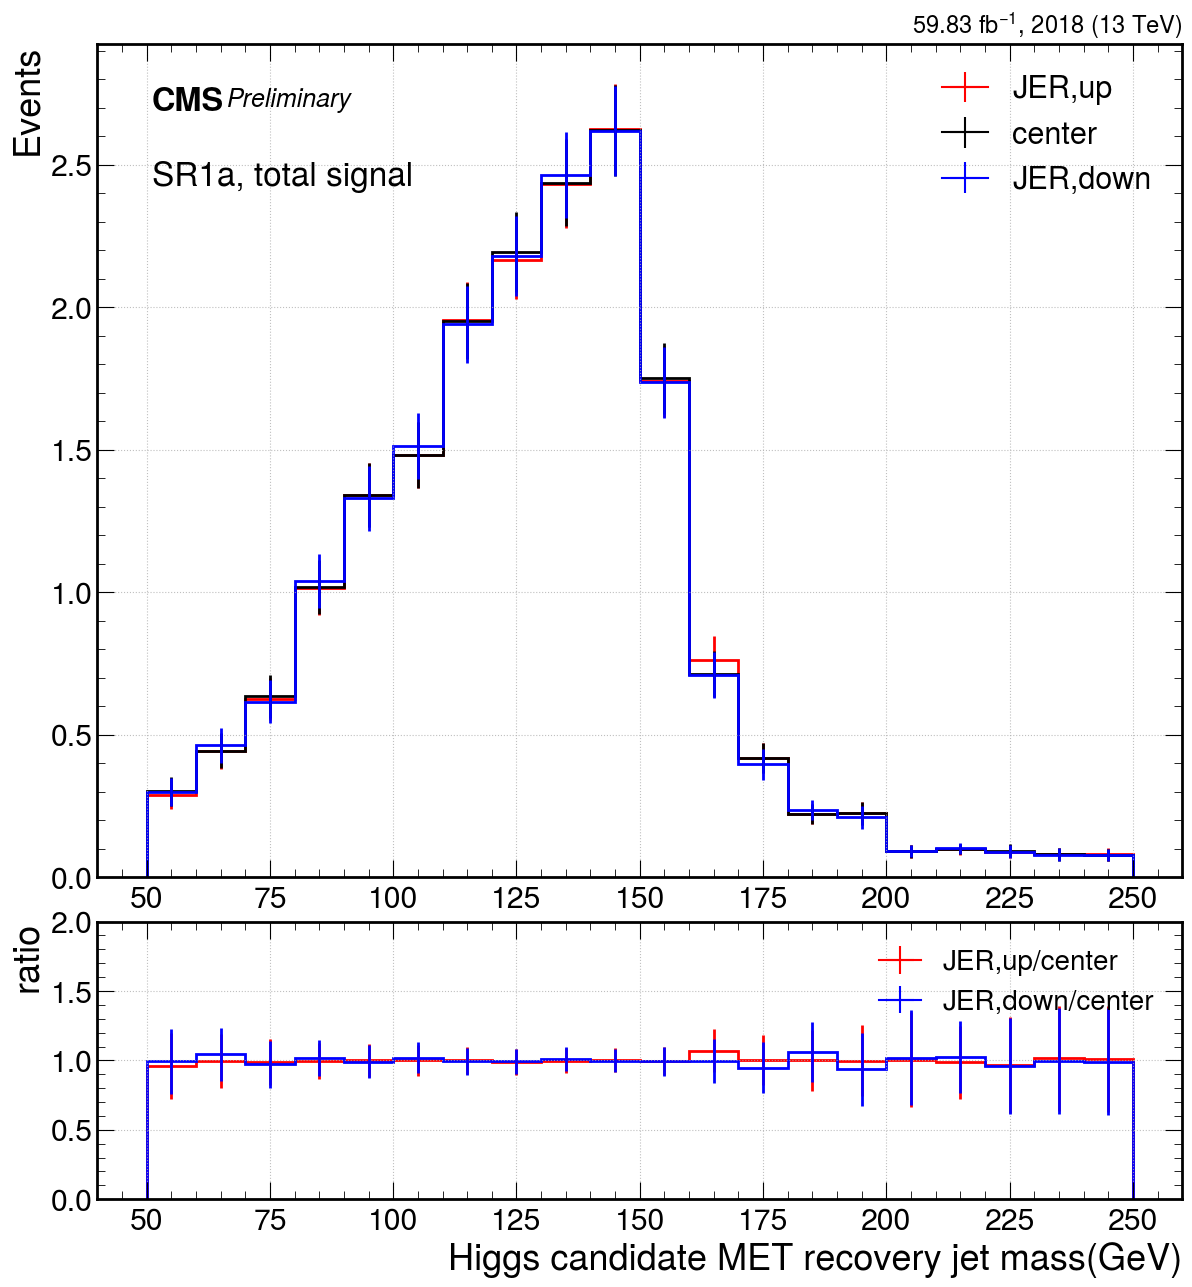

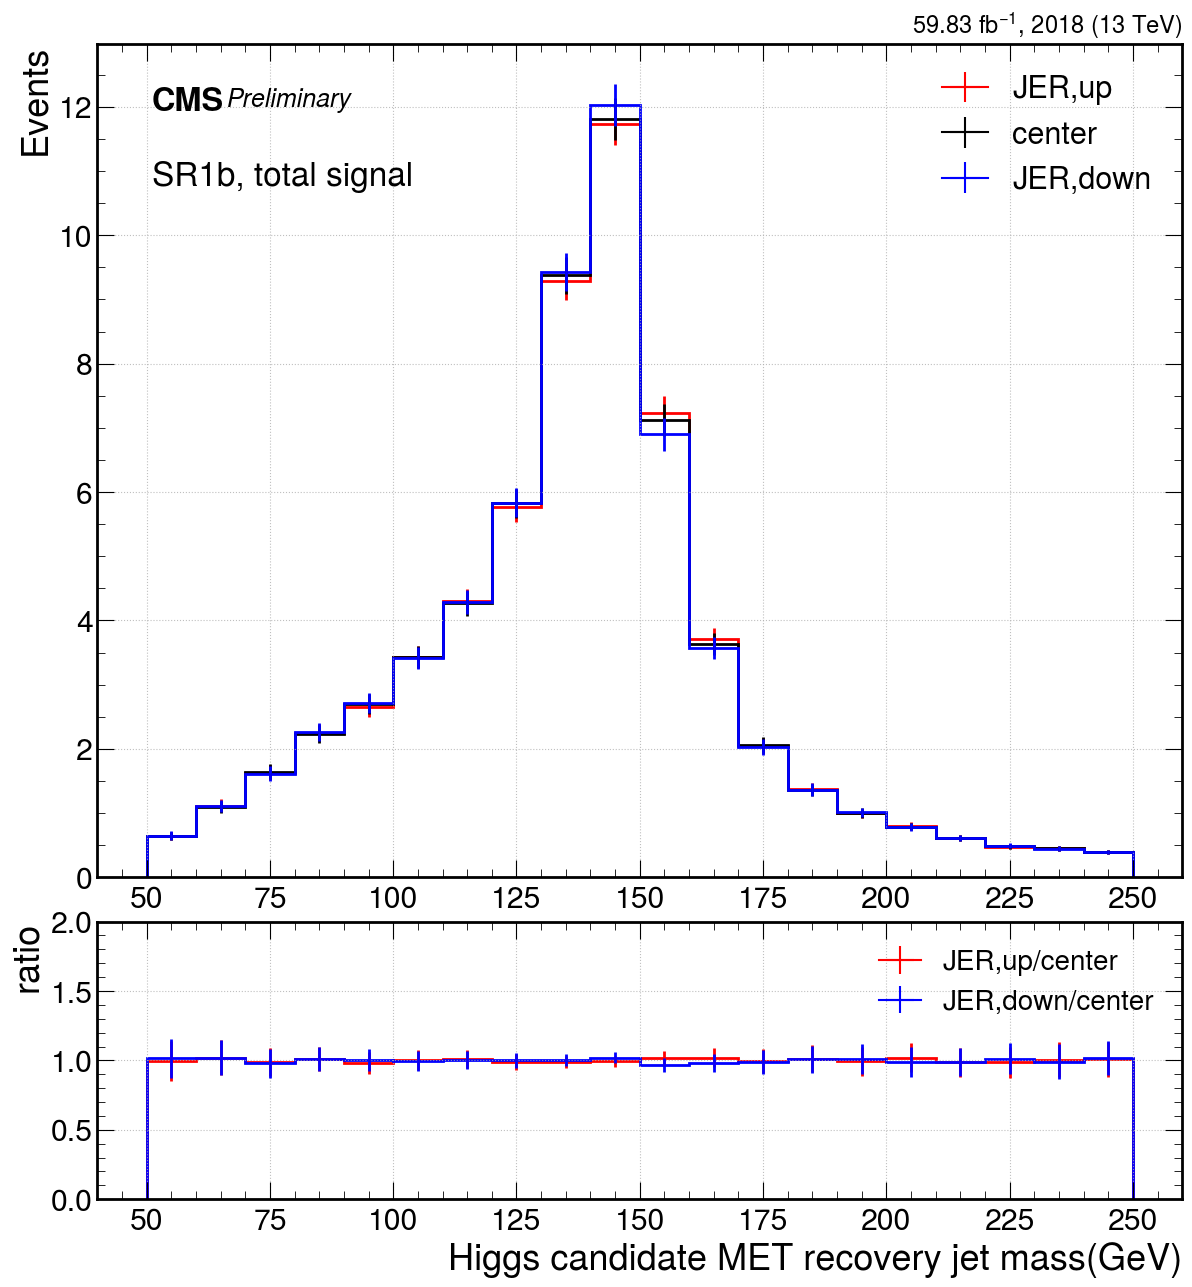

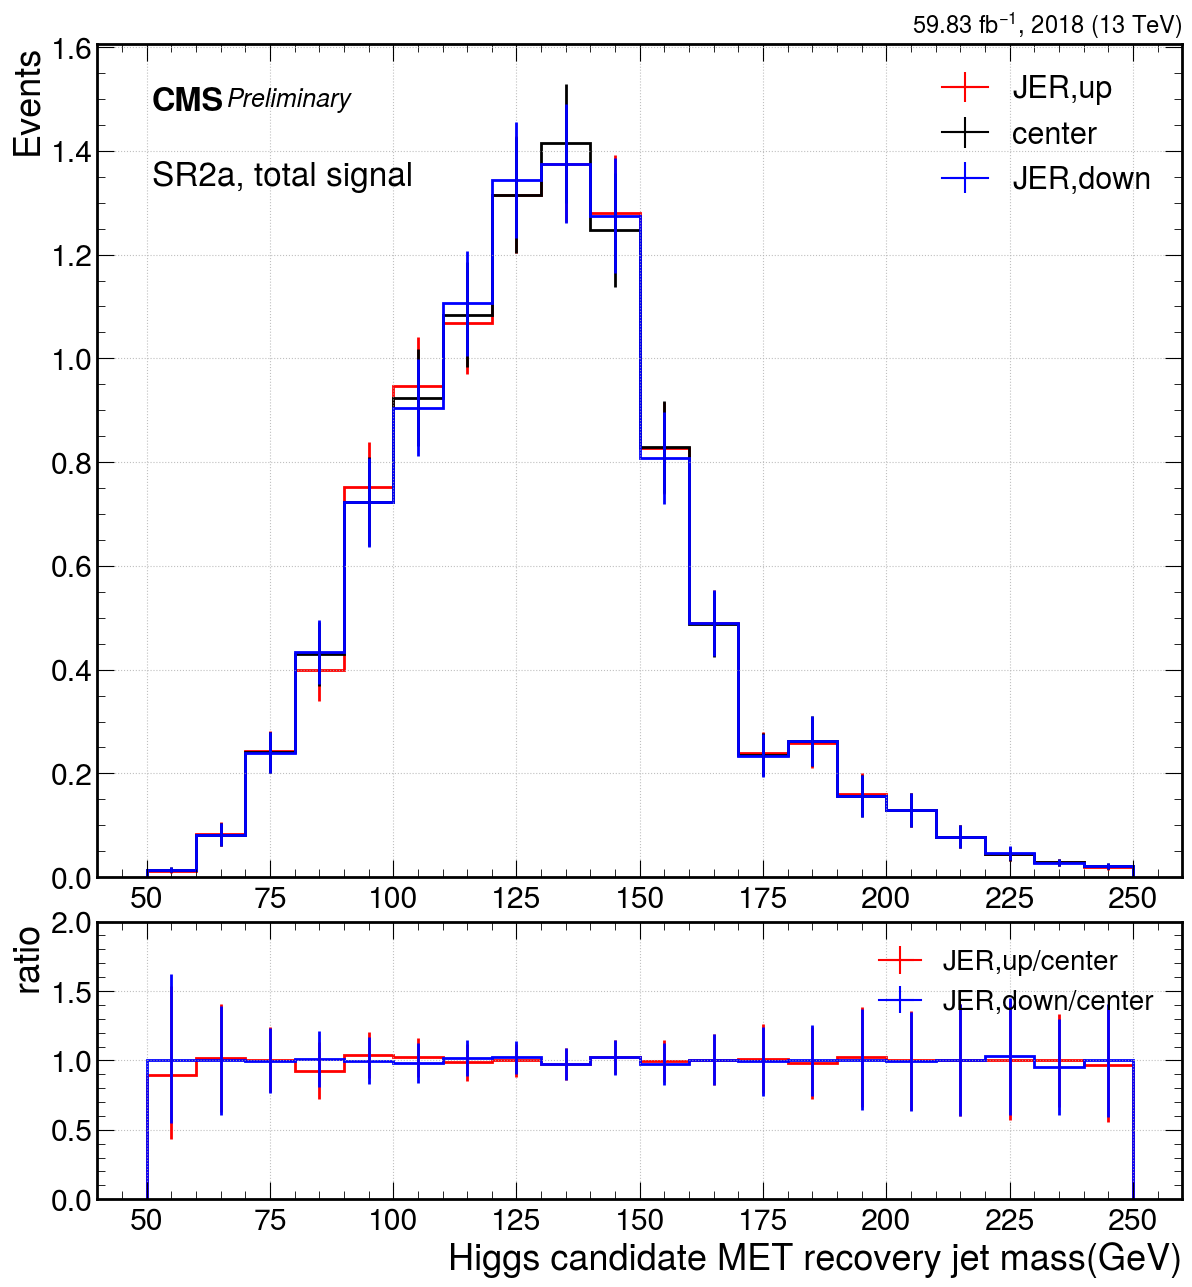

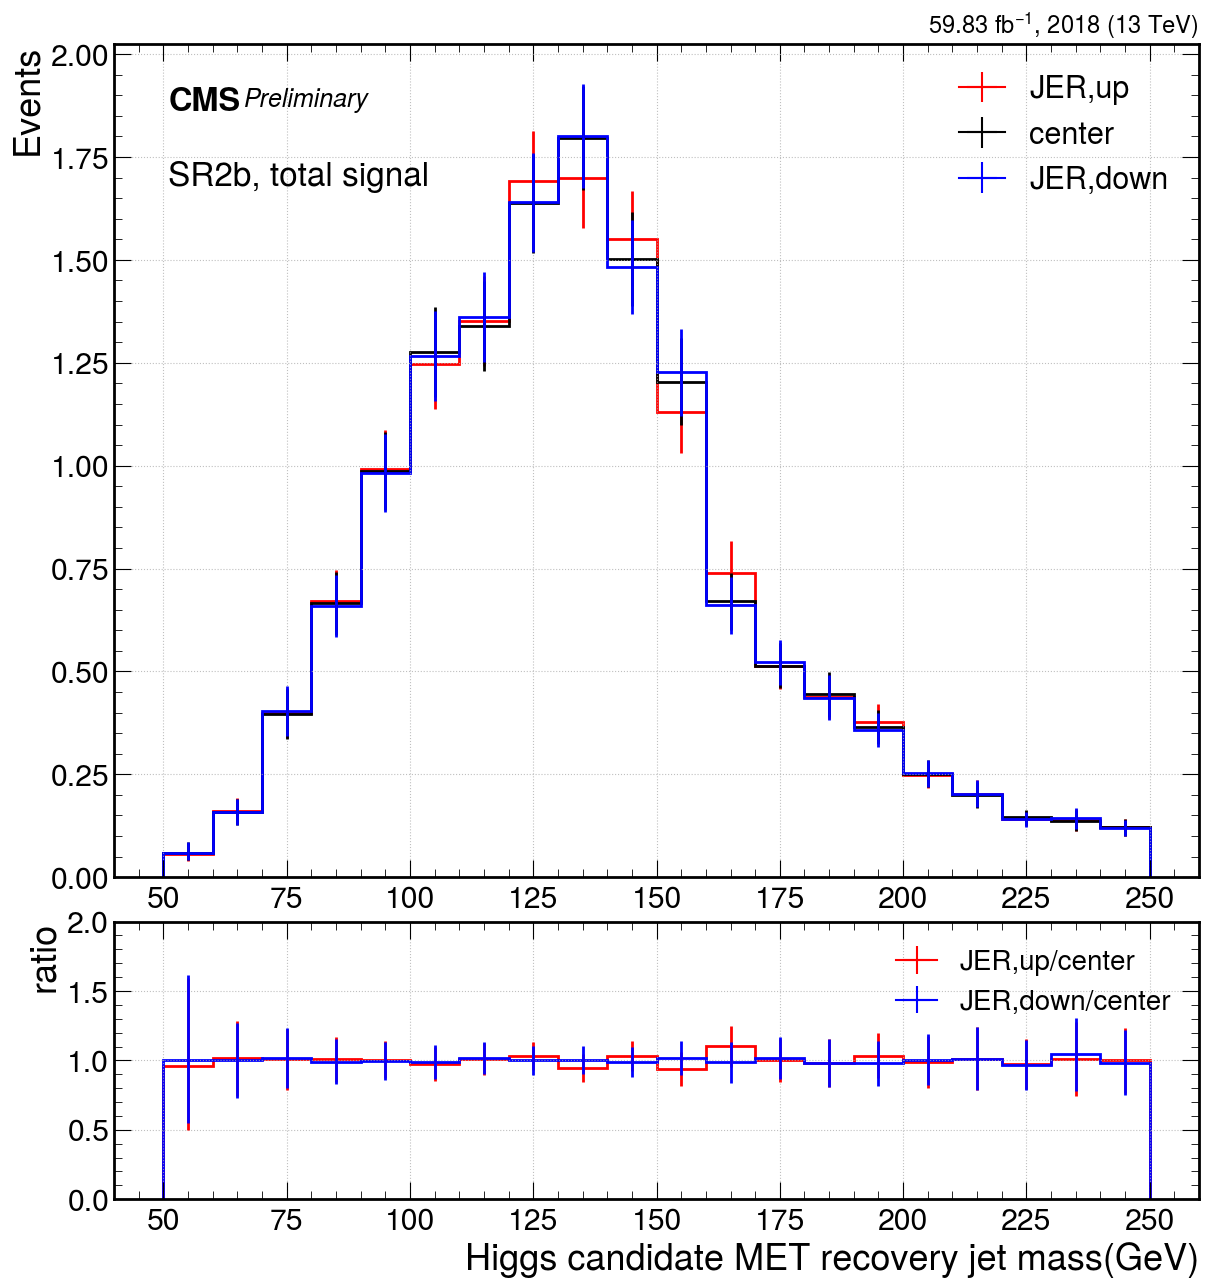

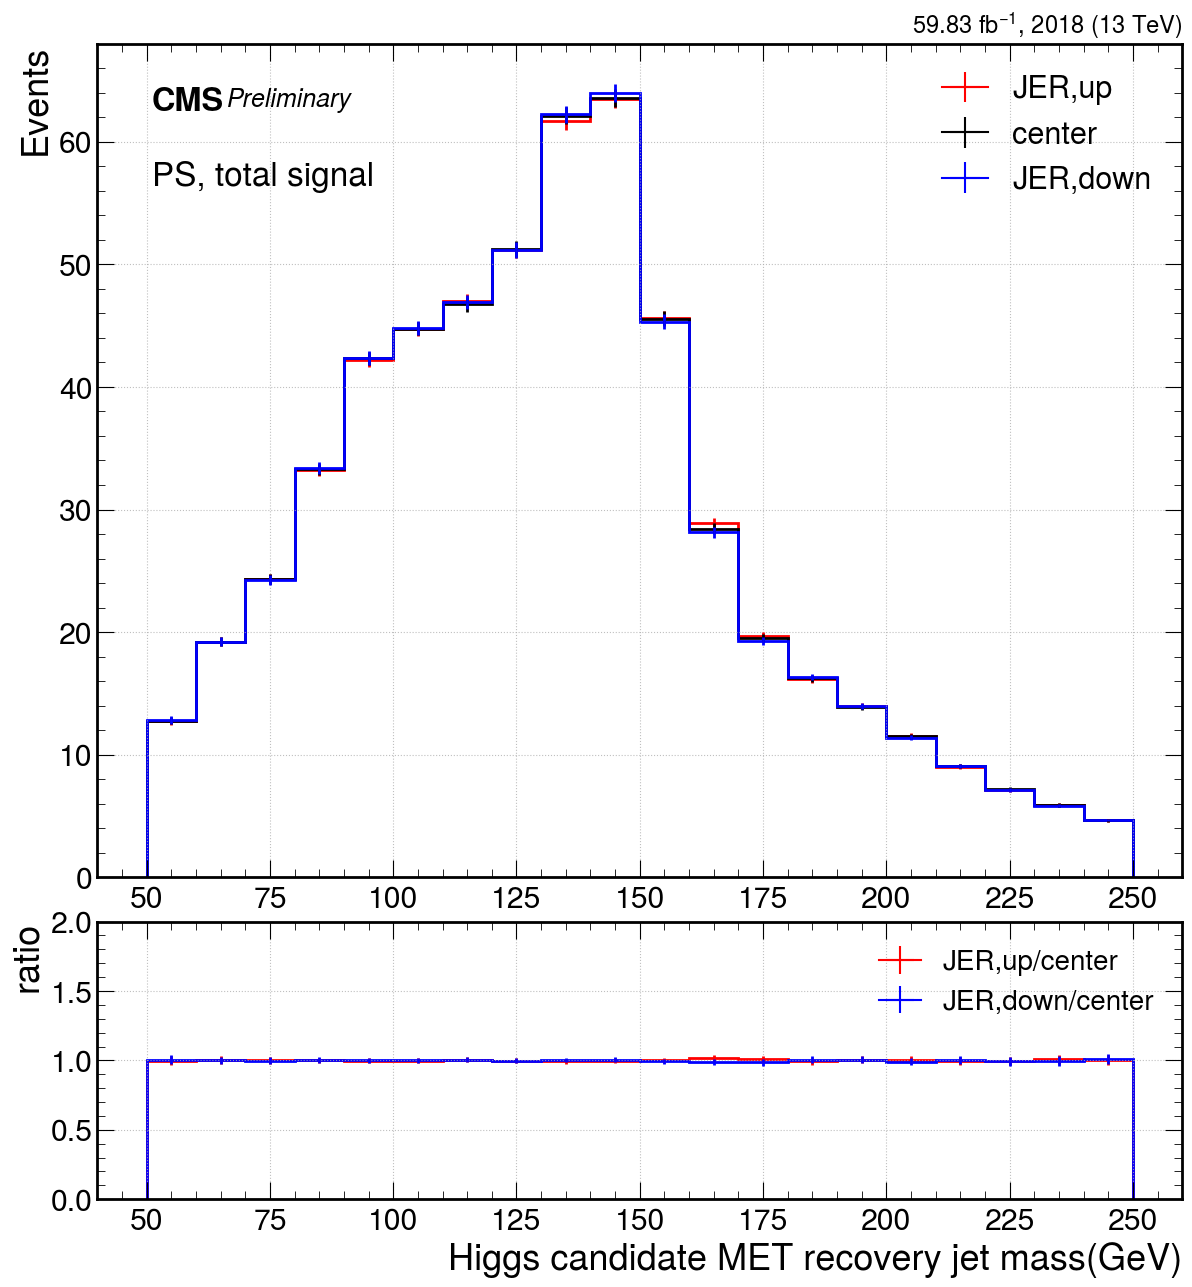

In [12]:
plot_JES_JER_variation(files["TotalSignal"],region = "SR1a")
plot_JES_JER_variation(files["TotalSignal"],region = "SR1b")
plot_JES_JER_variation(files["TotalSignal"],region = "SR2a")
plot_JES_JER_variation(files["TotalSignal"],region = "SR2b")
plot_JES_JER_variation(files["TotalSignal"],region = "PS")

plot_JES_JER_variation(files["TotalSignal"],plot_JES = False, region = "SR1a")
plot_JES_JER_variation(files["TotalSignal"],plot_JES = False, region = "SR1b")
plot_JES_JER_variation(files["TotalSignal"],plot_JES = False, region = "SR2a")
plot_JES_JER_variation(files["TotalSignal"],plot_JES = False, region = "SR2b")
plot_JES_JER_variation(files["TotalSignal"],plot_JES = False, region = "PS")

### analyze JMS and JMR variation

### analyze pu weight up/down variation

In [15]:
def plot_pu_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_pu = True,year = "2018"):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_pu:
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["puWeightUp"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="pileup(PU), up variation", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["puWeightDown"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="pileup(PU), down variation", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="up var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="down var./center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region + ", total signal",fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/PU_{year}_{region}.pdf", bbox_inches='tight')    



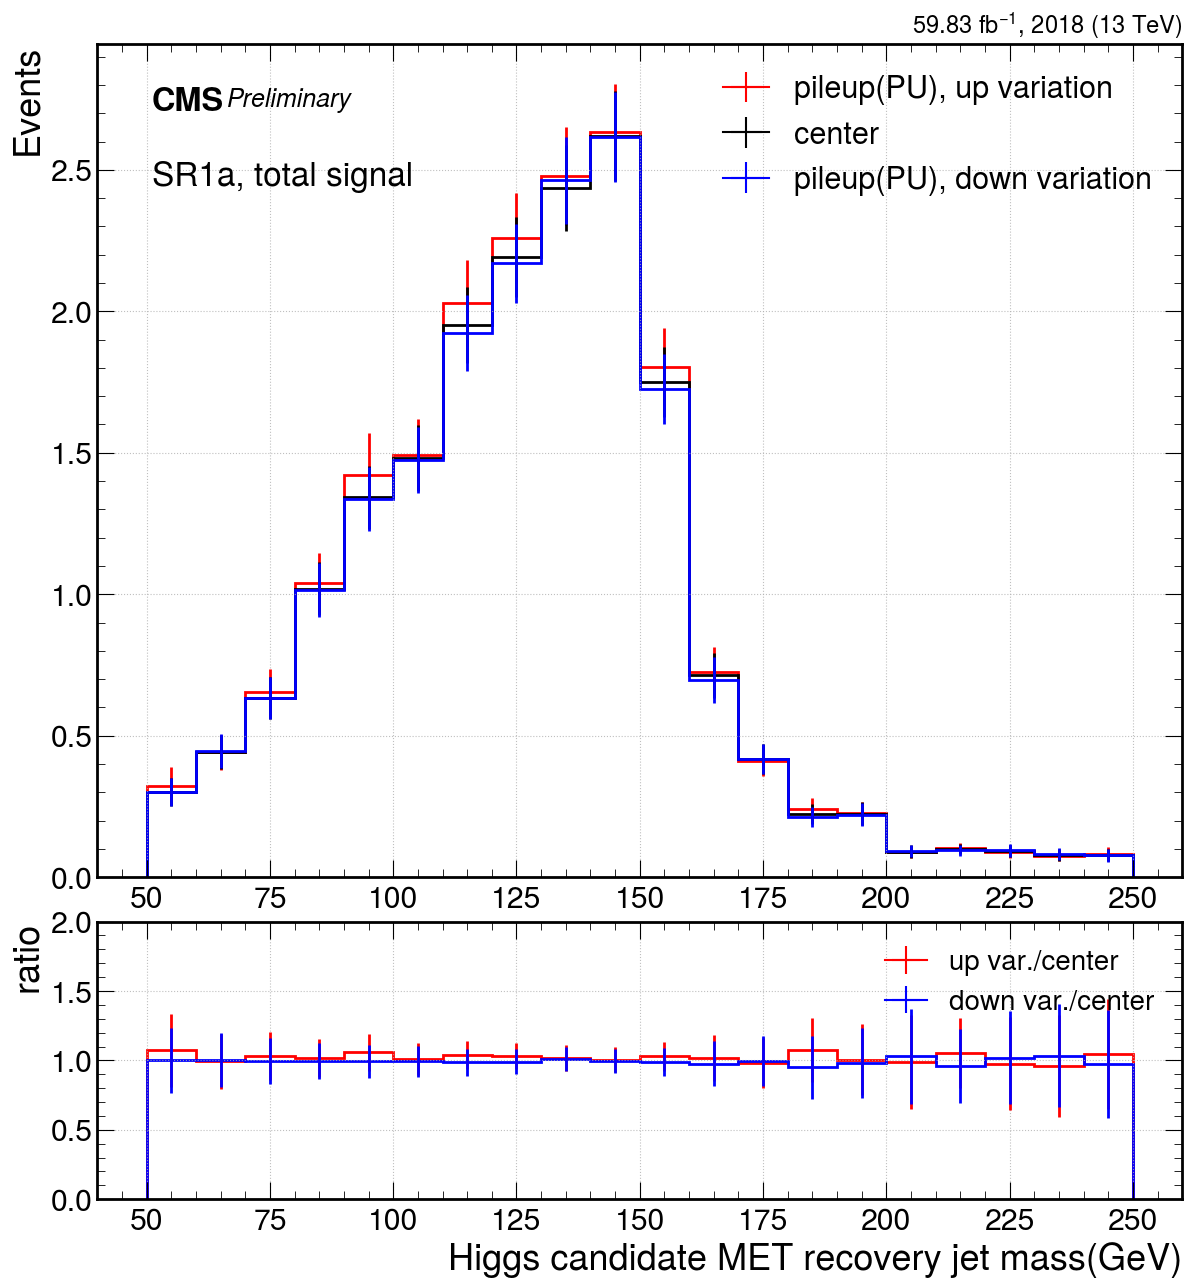

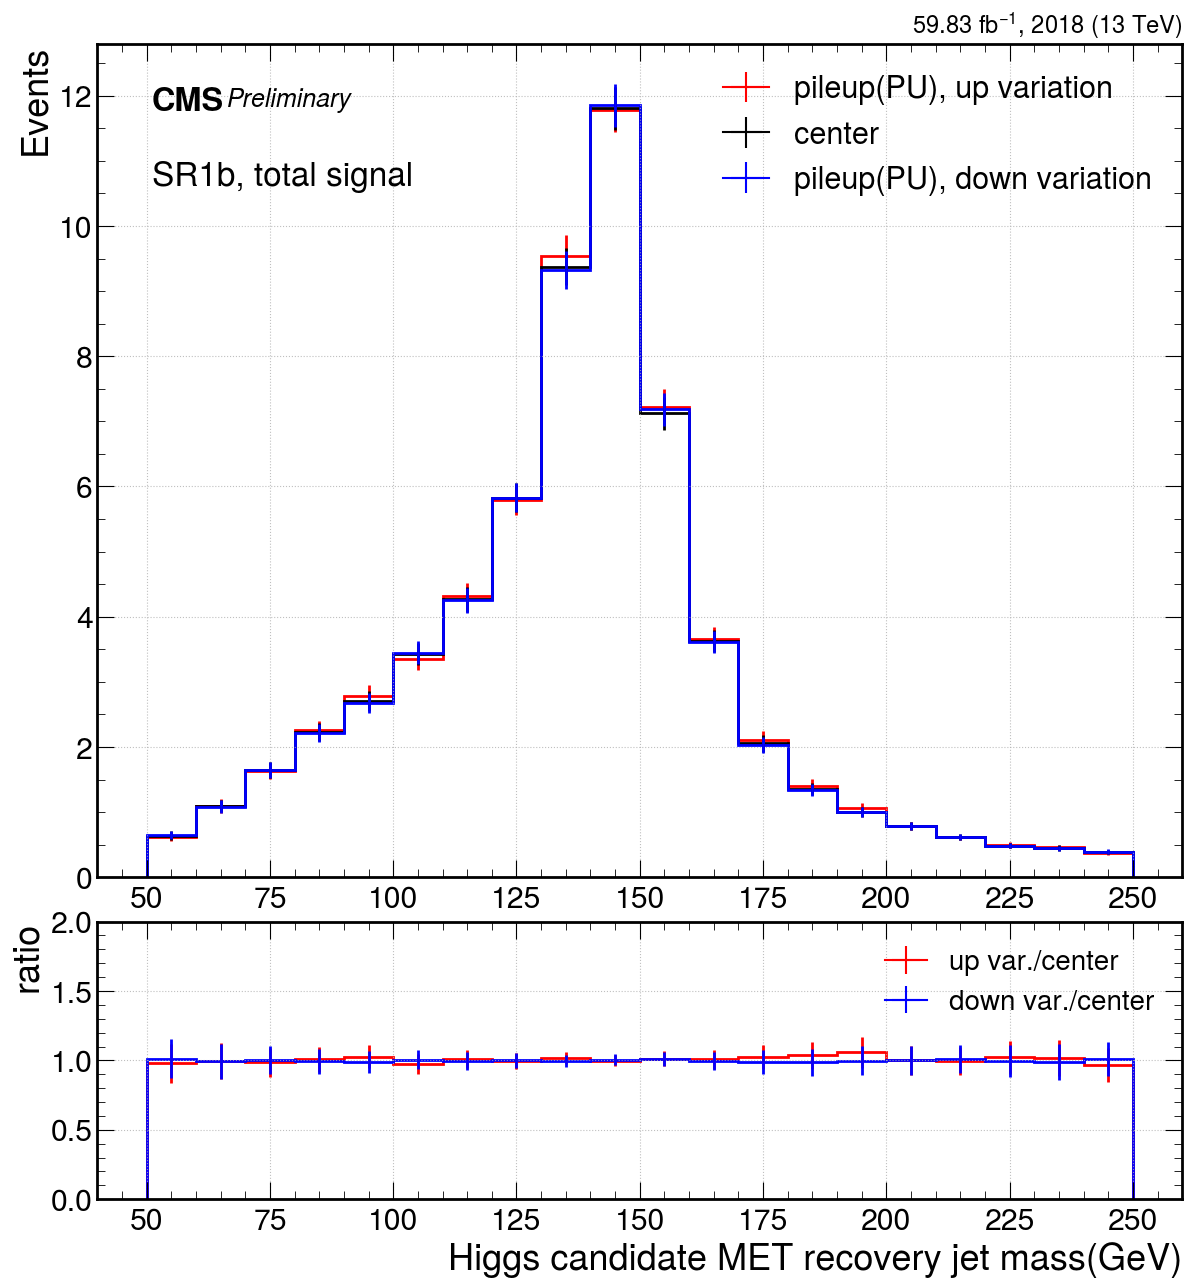

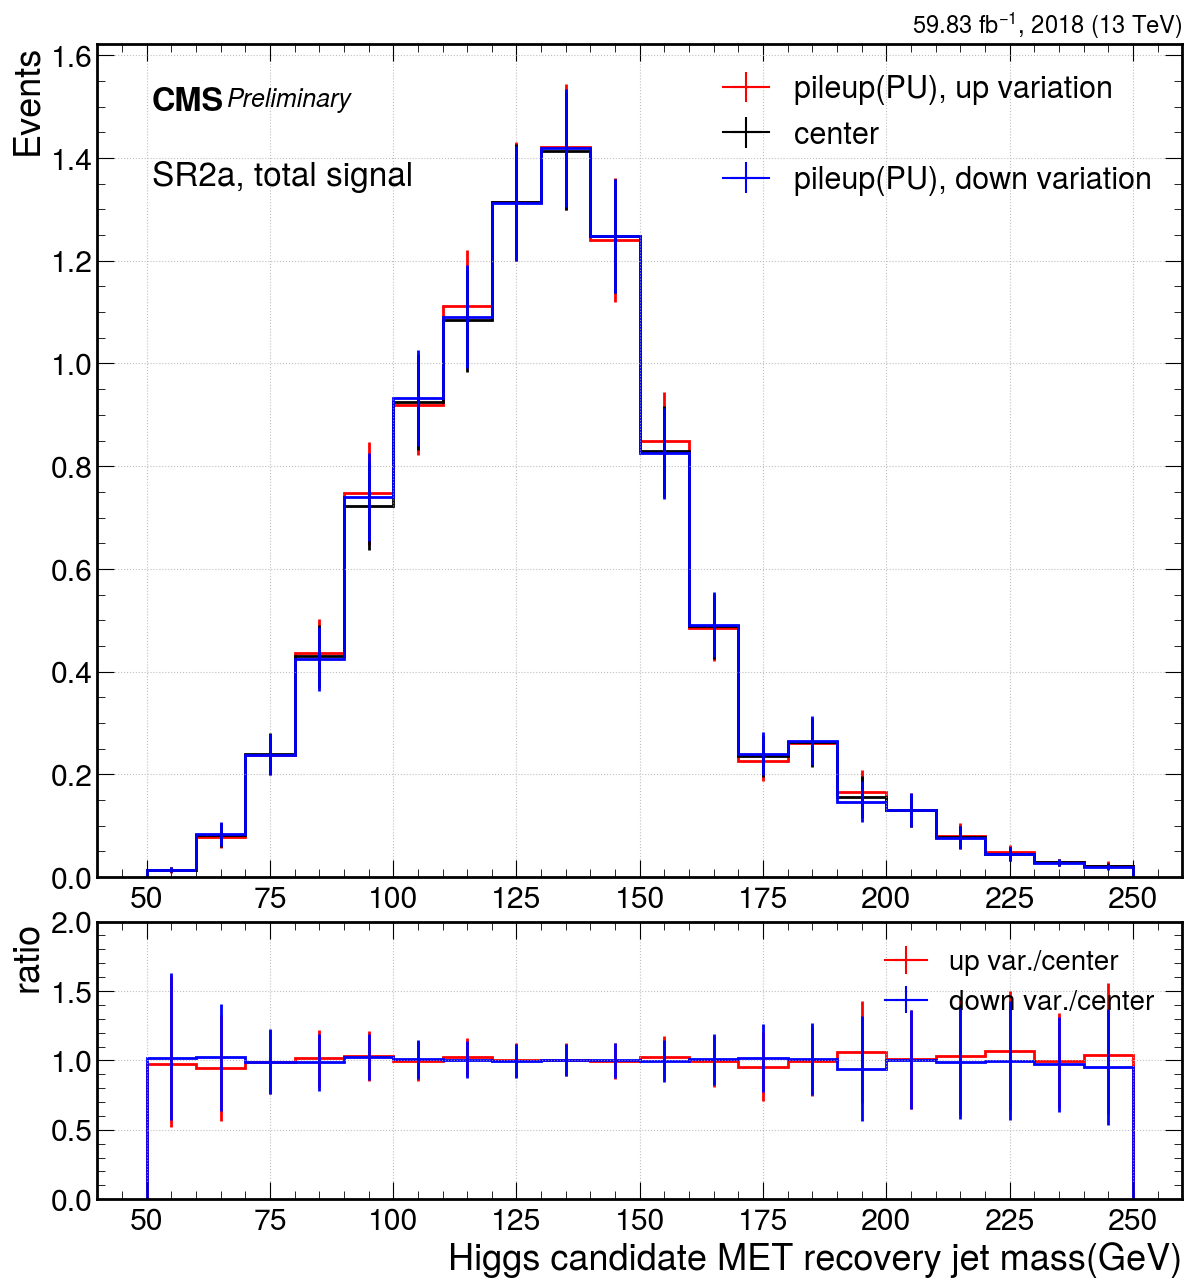

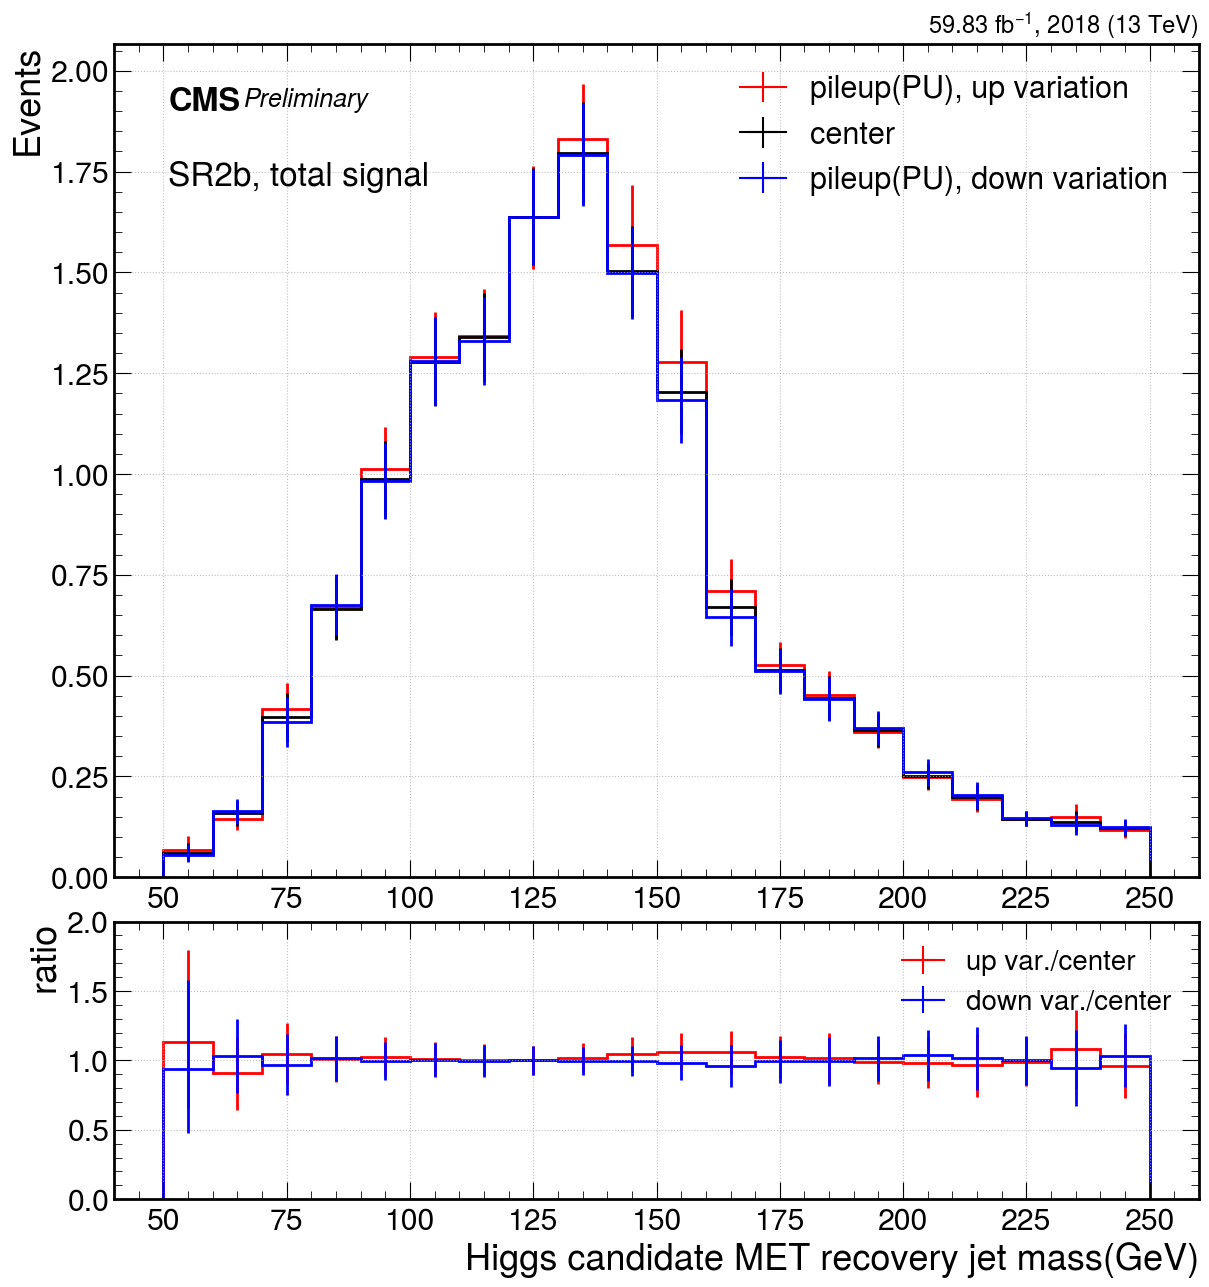

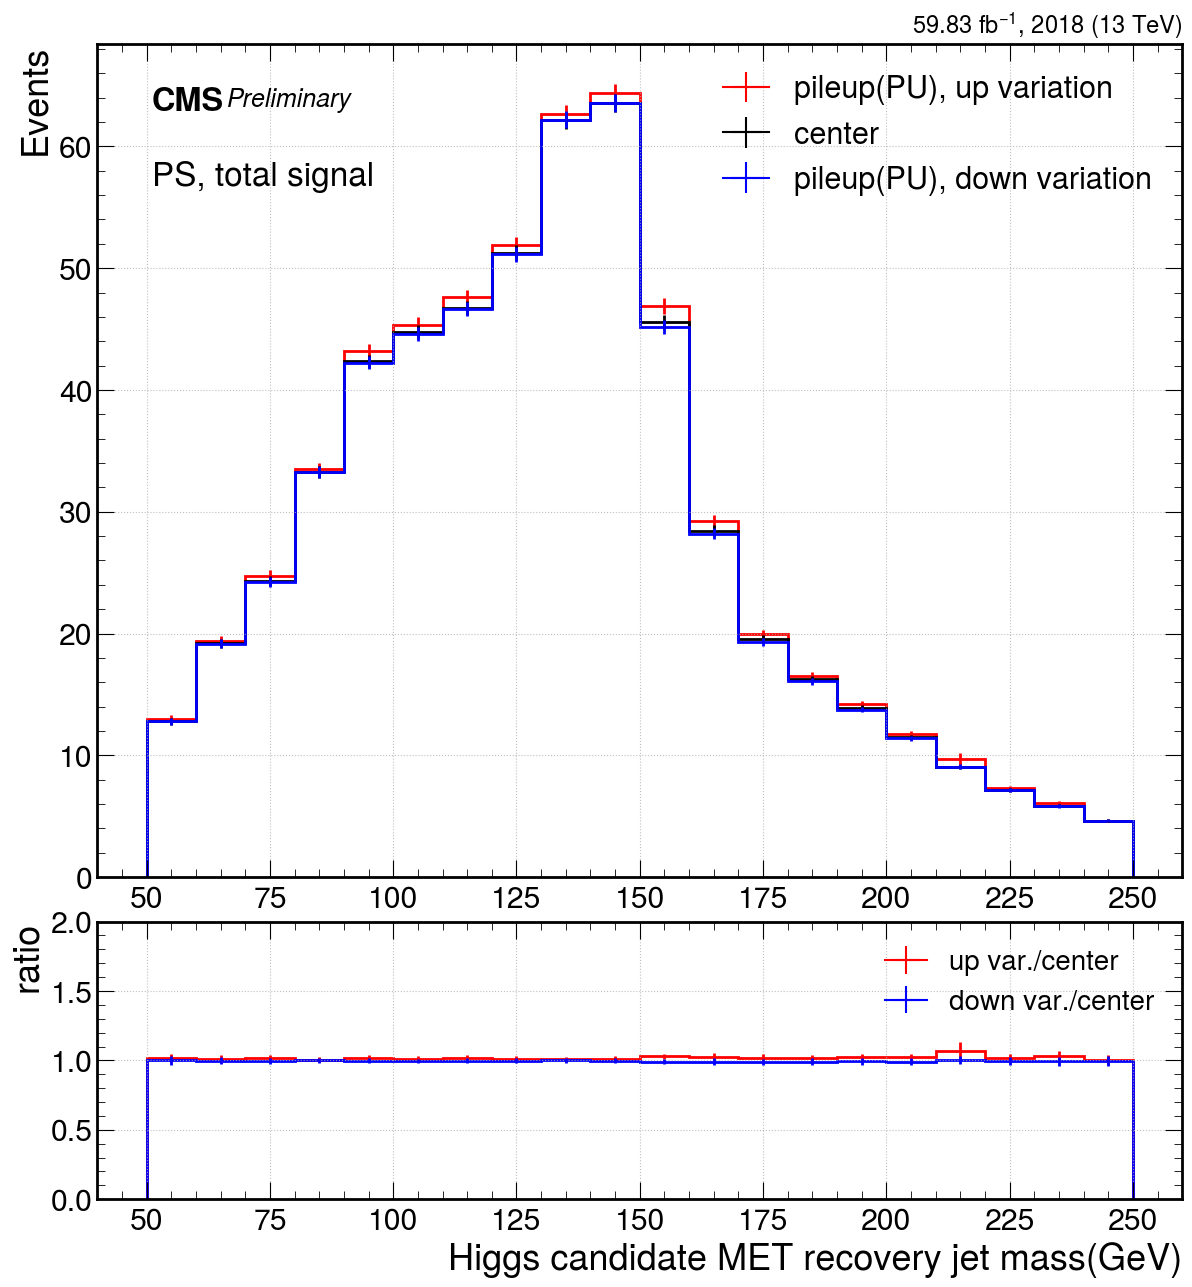

In [16]:
plot_pu_variation(files["TotalSignal"],region = "SR1a")
plot_pu_variation(files["TotalSignal"],region = "SR1b")
plot_pu_variation(files["TotalSignal"],region = "SR2a")
plot_pu_variation(files["TotalSignal"],region = "SR2b")
plot_pu_variation(files["TotalSignal"],region = "PS")

### analyze LHE Scale weight variation

In [9]:
#load the slimmedtree files using uproot

#different year available here.
# year = "2016"
# year = "2017"
year = "2018"
# year = "Full-Run2"

#if run on PKU cluster, use this:
CustNanoData = {
    'TotalSignal' : "/data/bond/zhaoyz/Tree/V9/%s/Merged/Signal/Tree_Total.root"%(year),
    'ggF'         : "/data/bond/zhaoyz/Tree/V9/%s/Merged/Signal/Tree_GluGlu.root"%(year),
    'VH'          : "/data/bond/zhaoyz/Tree/V9/%s/Merged/Signal/Tree_VH.root"%(year),
    'ttH'         : "/data/bond/zhaoyz/Tree/V9/%s/Merged/Signal/Tree_ttH.root"%(year),
    'VBF'         : "/data/bond/zhaoyz/Tree/V9/%s/Merged/Signal/Tree_VBF.root"%(year),
} 

files_tree = {typefile : {} for typefile in CustNanoData}
for typefile in CustNanoData:
    files_tree[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree" })

In [10]:
for k in files_tree:
    print("processing:",k)
    get_dphi(events=files_tree[k])
    get_reco(events=files_tree[k])

processing: TotalSignal
[0.486, 0.0852, 0.232, 2.85, 3.1, 3.14, ... 0.839, 3.07, 2.31, 2.44, 2.99, 0.506]
processing: ggF
[0.486, 0.0852, 0.232, 2.85, 3.1, 3.14, ... 3.11, 0.0275, 2.64, 3.07, 0.455, 2.21]
processing: VH
[3.03, 2.65, 1.91, 2.1, 3.06, 0.382, ... 0.753, 0.141, 0.273, 0.498, 1.18, 2.73]
processing: ttH
[1.1, 0.131, 0.429, 1.78, 2.46, 0.0163, ... 0.839, 3.07, 2.31, 2.44, 2.99, 0.506]
processing: VBF
[0.435, 0.297, 1.79, 3.09, 1.14, 0.797, 2.77, ... 0.332, 2.5, 2.07, 2.82, 2.01, 2.45]


### Test some weight(LHE Scale Weight, PS Weight)

In [11]:
files_tree["TotalSignal"].LHEScaleWeight[0]


<Array [1.29, 1.24, 1.19, ... 0.815, 0.768] type='9 * float32'>

In [12]:
files_tree["TotalSignal"].PSWeight[0]


<Array [0.909, 0.518, 1.12, 1.77] type='4 * float32'>

### Test MET UE(unclusted energy) up/down variation

In [13]:
files_tree["TotalSignal"].MET_et_UEup


<Array [104, 332, 77.8, ... 26.9, 55.2, 102] type='287681 * float32'>

In [15]:
files_tree["TotalSignal"].MET_et

<Array [110, 329, 77.1, 28.9, ... 26, 55.9, 99] type='287681 * float32'>

In [14]:
files_tree["TotalSignal"].MET_et_UEdown


<Array [117, 326, 76.7, ... 26.1, 56.5, 96.5] type='287681 * float32'>

### Plot LHE Scale variation

In [19]:
def plot_LHEScale_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_pu = True,year = "2018"):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_pu:
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["LHEScaleWeight"][maskdict_sr(files,region)][:,0])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="pileup(PU), up variation", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["LHEScaleWeight"][maskdict_sr(files,region)][:,1])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["LHEScaleWeight"][maskdict_sr(files,region)][:,2])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="pileup(PU), down variation", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="up var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="down var./center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region + ", total signal",fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/LHEScale_{year}_{region}.pdf", bbox_inches='tight')    



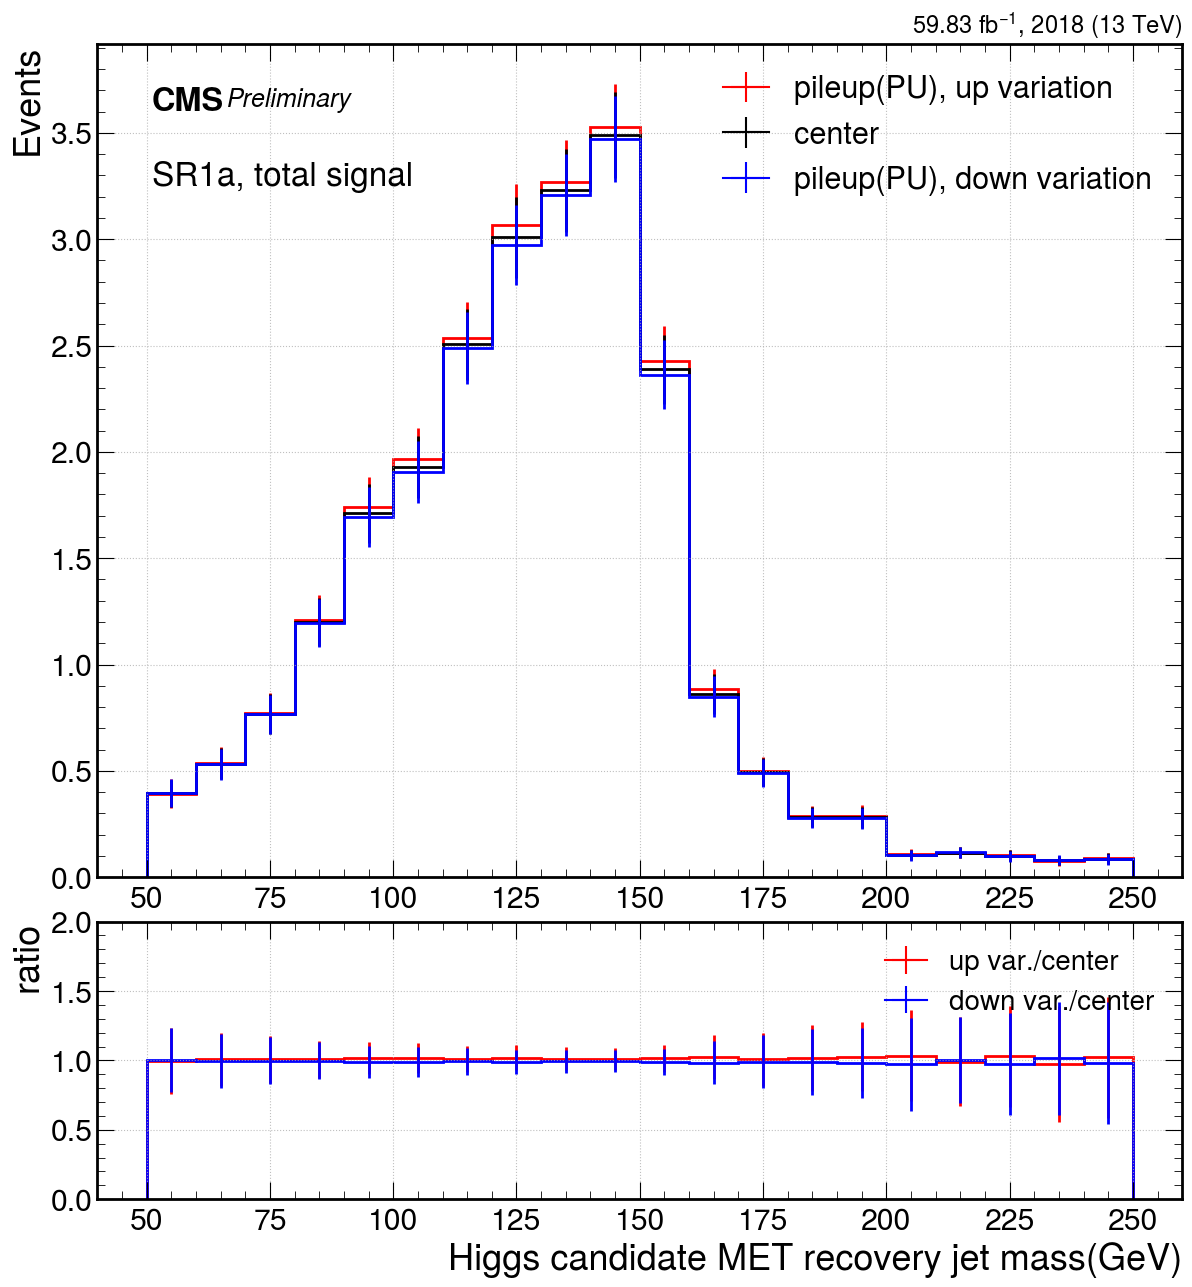

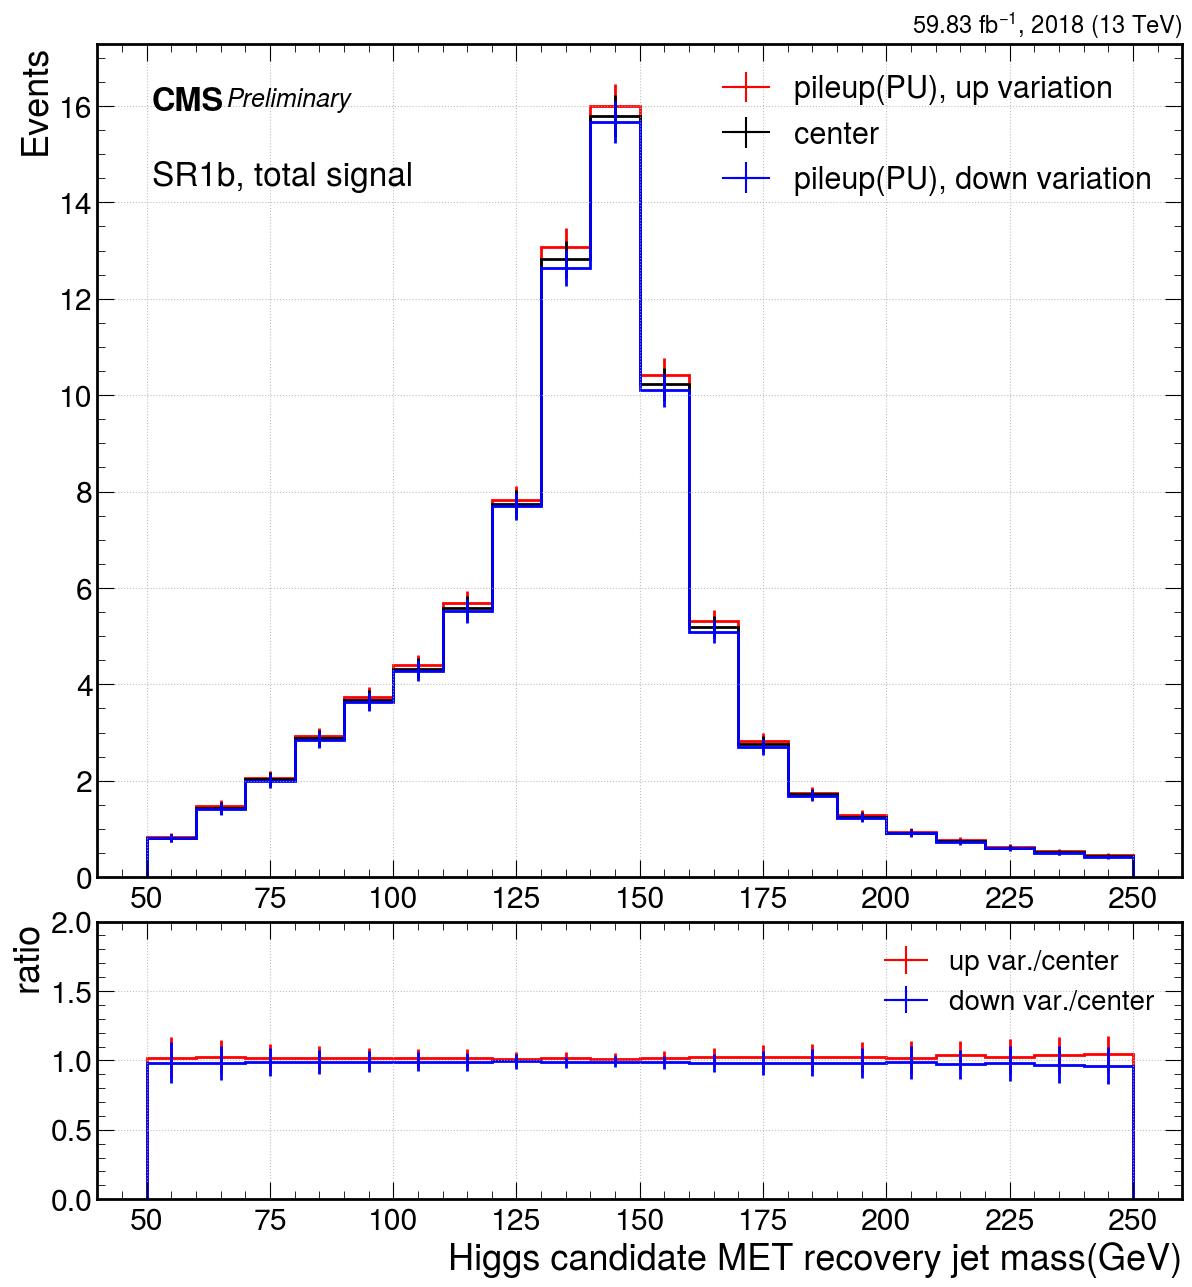

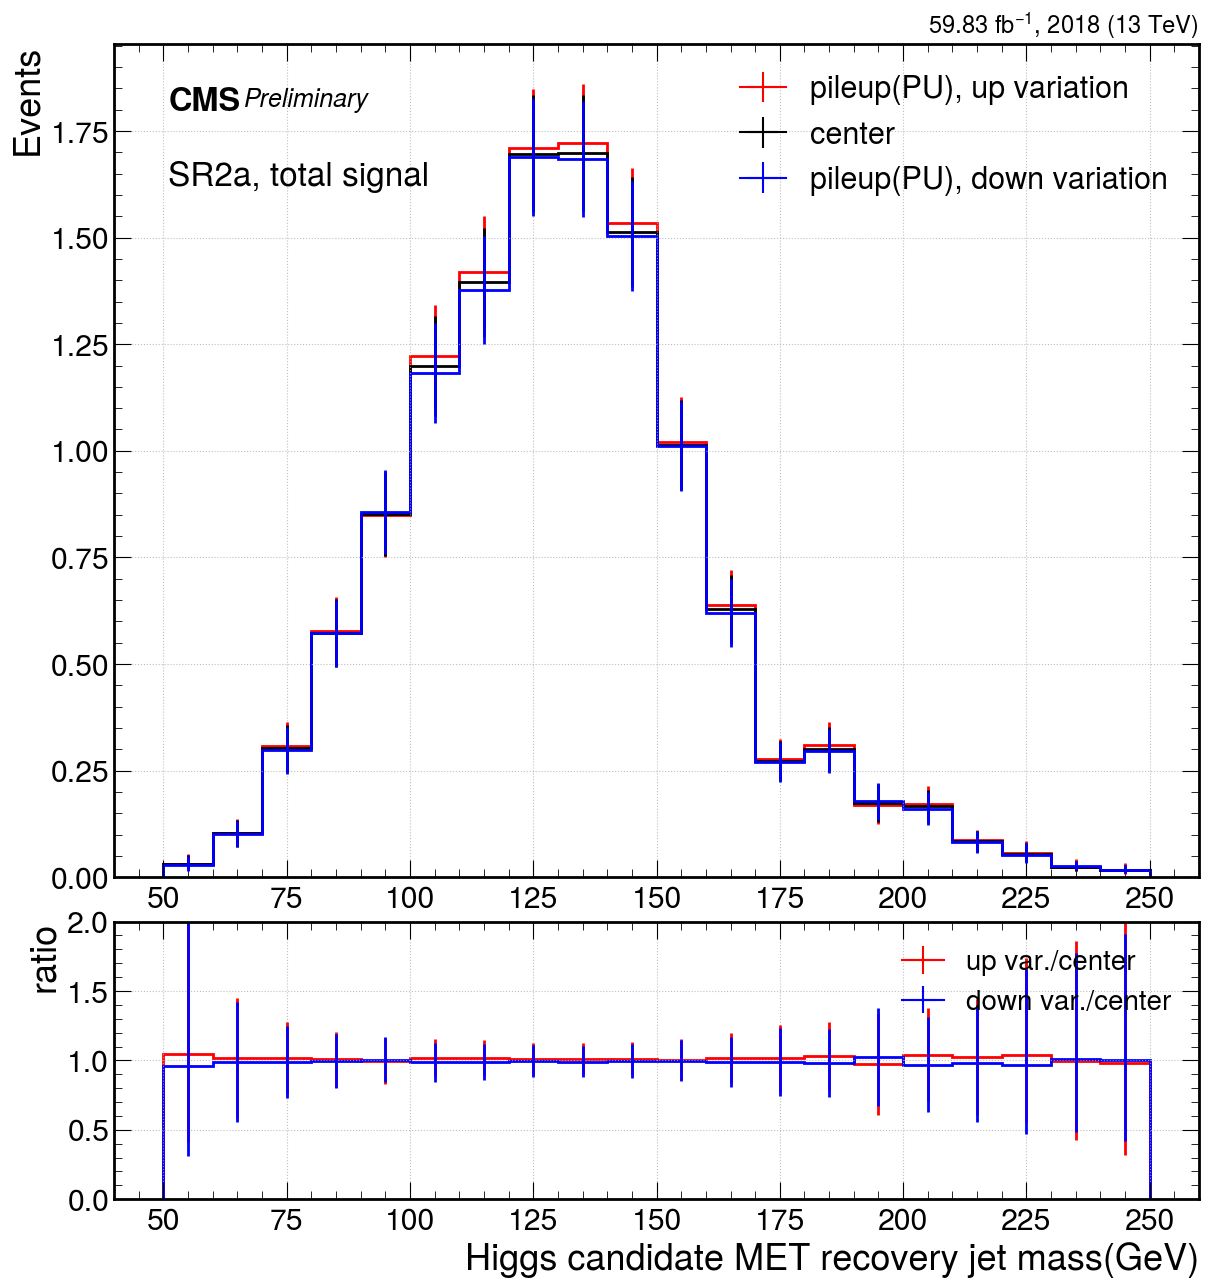

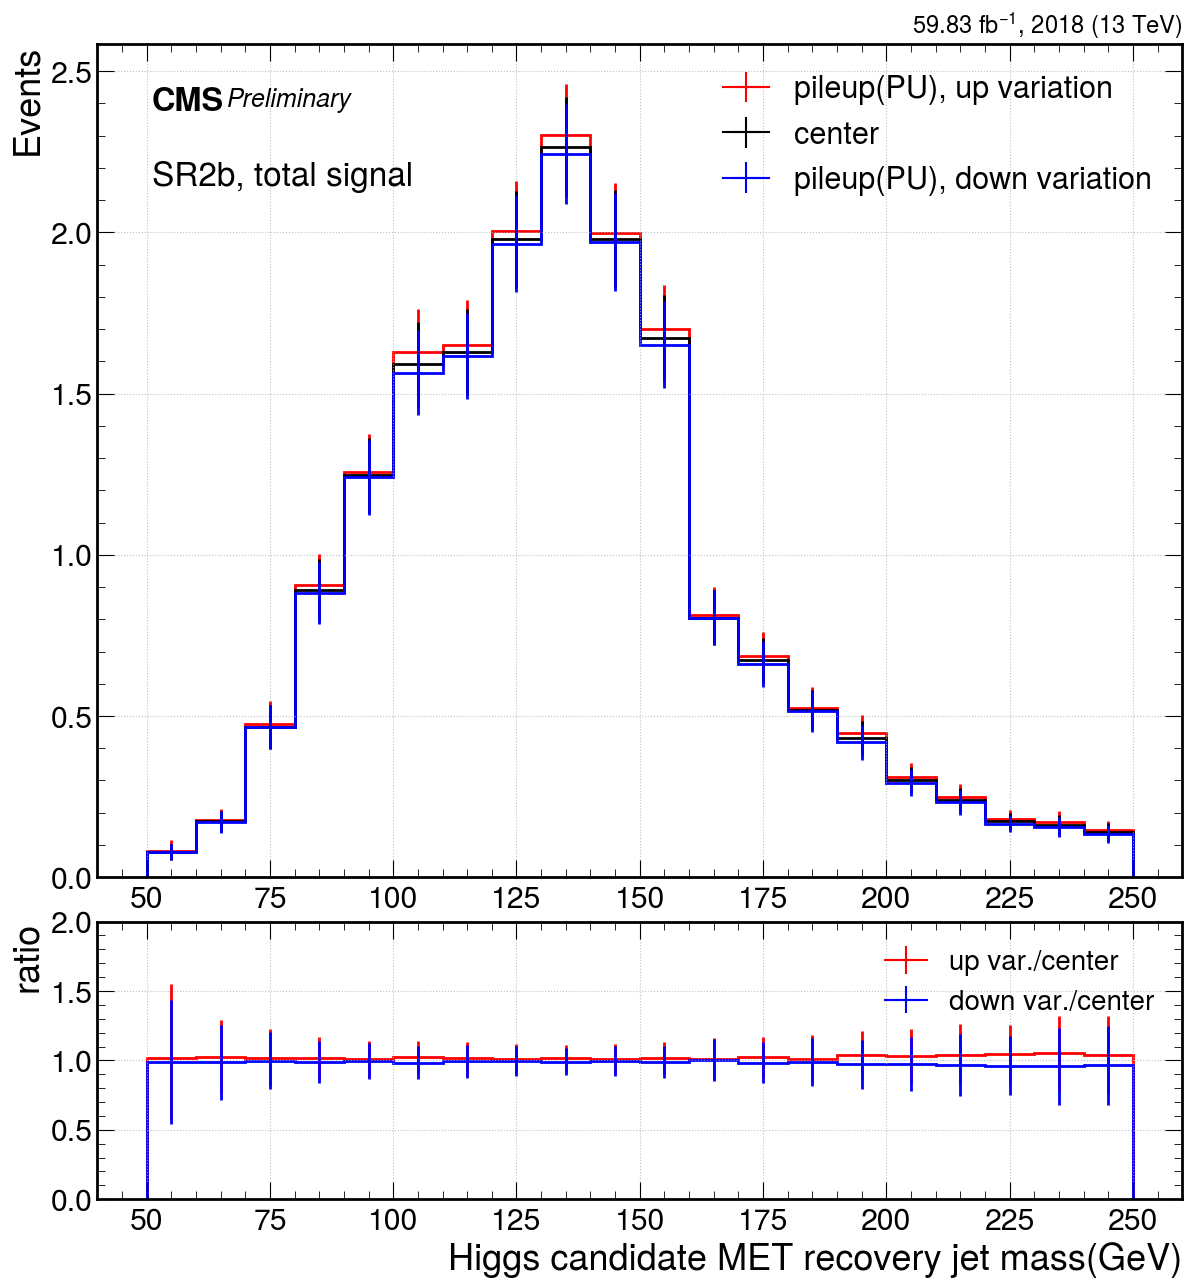

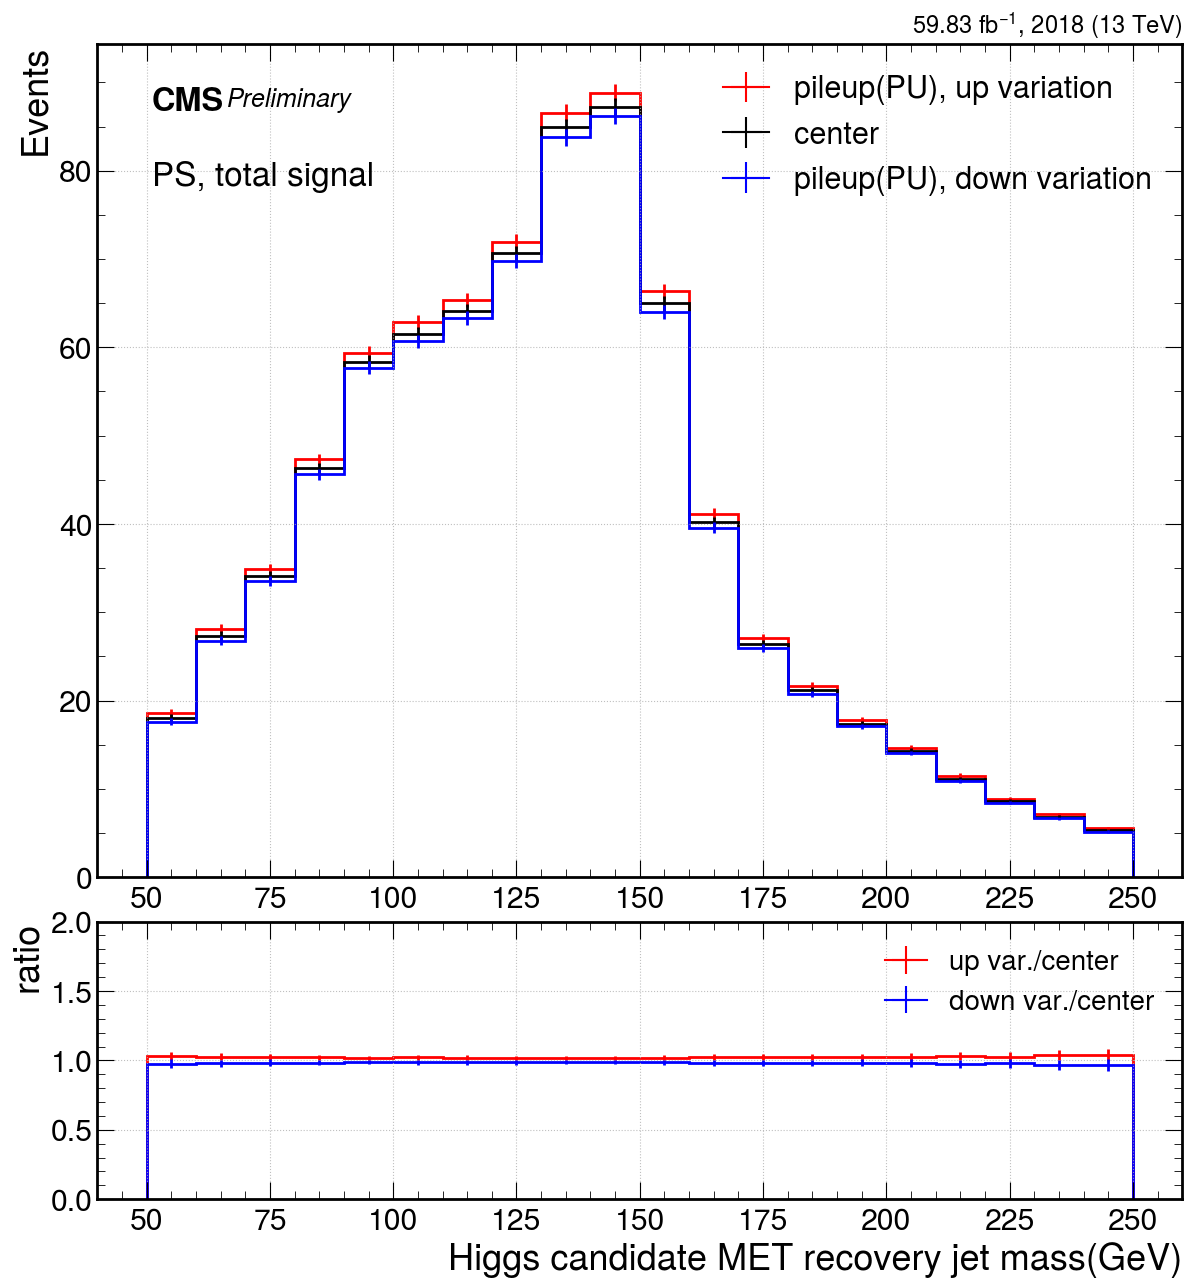

In [20]:
plot_LHEScale_variation(files_tree["TotalSignal"],region = "SR1a")
plot_LHEScale_variation(files_tree["TotalSignal"],region = "SR1b")
plot_LHEScale_variation(files_tree["TotalSignal"],region = "SR2a")
plot_LHEScale_variation(files_tree["TotalSignal"],region = "SR2b")
plot_LHEScale_variation(files_tree["TotalSignal"],region = "PS")

### Plot PS weight variation

In [ ]:
def plot_PS_variation(files, nbins=20, x_min=50, x_max=250, legend_location='upper left',suffix = "", region = "PS", plot_pu = True,year = "2018"):
    # plt.rcParams['axes.prop_cycle'] = cycler(color=['red','blue','green','darkorange','cyan','black'])
    plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])
    # plt.figure(figsize=(14,10))
    f = plt.figure(figsize=(14, 15))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    LUMI = {"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
    hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    def maskdict_sr(files_i, SR):
        events = files_i
        if   SR == "SR1a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.99))
        elif SR == "SR2a": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.99) & (events["DPhi"] < 0.8))
        elif SR == "SR1b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] < 0.25 ) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99))
        elif SR == "SR2b": maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0.25) & (events["a_HWW_V2"] >= 0.92) & (events["a_HWW_V2"] < 0.99) & (events["DPhi"] < 0.8))
        elif SR == "PS":   maskdict_sr = ((events["MET_et"]/events["PTj_V2_a"] >= 0))
        else: print("invalid SR value")
        return maskdict_sr
    
    
    if plot_pu:
        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["puWeightUp"][maskdict_sr(files,region)])
        hist_value_up = flow(hist_region)[0]
        hist_var_up   = flow(hist_region)[1]
        err_up = np.nan_to_num(error_bar(hist_value_up, hist_var_up, type = "mc"), nan = 0)
        hep.histplot(hist_value_up, bins=hist_region.axes[0].edges, yerr=err_up, label="pileup(PU), up variation", histtype='step', stack=False, linewidth=2, ax=ax, color = "red")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)])
        hist_value_nom = flow(hist_region)[0]
        hist_var_nom   = flow(hist_region)[1]
        err_nom = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_nom, label="center", histtype='step', stack=False, linewidth=2, ax=ax,color = "black")

        hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
        hist_region.fill(files["MH_Reco"][maskdict_sr(files,region)], weight = files["weight"][maskdict_sr(files,region)]*files["puWeightDown"][maskdict_sr(files,region)])
        hist_value_down = flow(hist_region)[0]
        hist_var_down   = flow(hist_region)[1]
        err_down = np.nan_to_num(error_bar(hist_value_nom, hist_var_nom, type = "mc"), nan = 0)
        hep.histplot(hist_value_down, bins=hist_region.axes[0].edges, yerr=err_down, label="pileup(PU), down variation", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")
        
        err_up   = np.sqrt(np.power(err_up/hist_value_up,2) + np.power(err_nom/hist_value_nom,2))
        hep.histplot(hist_value_up/hist_value_nom,   bins=hist_region.axes[0].edges, yerr=err_up, color='red',  label="up var./center", histtype='step', density=False, stack=False, ax=ax1,linewidth=2)
        err_down = np.sqrt(np.power(err_down/hist_value_down,2) + np.power(err_nom/hist_value_nom,2))    
        hep.histplot(hist_value_down/hist_value_nom, bins=hist_region.axes[0].edges, yerr=err_down, color='blue', label="down var./center",histtype='step', density=False, stack=False, ax=ax1,linewidth=2)    

        ax1.set_xlabel("Higgs candidate MET recovery jet mass(GeV)")
        ax.set_ylabel("Events")
        ax1.set_ylabel("ratio")
        ax1.set_ylim(0, 2)
        # ax.set_yscale('log') 
        ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=22)
        ax1.legend(loc="upper right", ncol=1, frameon=False, fontsize=20)
        plt.text(0.05,0.83,region + ", total signal",fontsize=24, color="black", ha='left',transform=ax.transAxes)
        plt.savefig(f"{plot_dir}/PU_{year}_{region}.pdf", bbox_inches='tight')    



In [ ]:
plot_PS_variation(files["TotalSignal"],region = "SR1a")
plot_PS_variation(files["TotalSignal"],region = "SR1b")
plot_PS_variation(files["TotalSignal"],region = "SR2a")
plot_PS_variation(files["TotalSignal"],region = "SR2b")
plot_PS_variation(files["TotalSignal"],region = "PS")